In [52]:
# from kaggle.competitions import twosigmanews
# __env__ = twosigmanews.make_env()

# definitely not production code

hashtags: #edit #todo #note #float32 #new #del 1/0 #nope

debug vars: SEE DEBUG TEST PROD BUG

In [53]:
# from common import *
# from pandas.api.types import CategoricalDtype
# import warnings 
# warnings.filterwarnings('ignore')
# %matplotlib inline
# canvas(12,12)

In [54]:
# ho_time = pd.Timestamp('2015-07-01',tz='UTC')

# def fake(*,M,N):
#     M_, N_ = M, N
#     for time, M in M_.groupby('time'):
#         if time<ho_time:
#             continue
#         M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
#         P = M[excluded_columns]
#         M = M.drop(columns=['returnsOpenNextMktres10','quarter'])
#         P['confidenceValue'] = 0.
#         yield M, None, P

In [55]:
# from common import *

### important devops code

In [56]:
TEST = False
SEE = NULL = lambda*a,**k:None
TRAIN = True

In [57]:
# relevant file names #TODO change it #NOPE(but change it)
FILE_WORK = '/big/data/_work.pkl'
FILE_MSTART = '/big/data/Mstart.pkl'

# #################################################### START HERE

# #NOPE things here until the next #NOPE

In [58]:
# import pandas as pd
# M = pd.read_pickle('../data/given/M.pkl') # market obs
# N = None #pd.read_pickle('../data/given/N.pkl') # news
# #test = pd.read_pickle('../data/given/test.pkl')

In [59]:
def _make_env():
    '''this creates a testing version of the actual env from Kaggle kernels'''
    class __env__():
        _submitted = []
        # -1 = begin, 0 = just yielded, 1 = just predicted, -2 = finished, -3 = finished and submission file written too
        _states = [-1]

        class KaggleEnvError(Exception):
            pass

        @staticmethod
        def get_training_data():
            return pd.read_pickle('../data/given/M.pkl'), None
#             global N
#             try:
#                 return M, N
#             except NameError:
#                 return M, None

        @staticmethod
        def get_prediction_days():
            env = __class__

            class iter_get_prediction_days():
                def __iter__(self):
                    if env._states[-1] != -1:
                        raise env.KaggleEnvError('can only call get_prediction_days once!')
                    
                    global test
                    test = pd.read_pickle('../data/given/test.pkl')
                    env._days_iter = test.__iter__()
                    return self

                def __next__(self):
                    if env._states[-1] == 0:
                        raise env.KaggleEnvError('can only yield next day after the previous day was submitted')
                    elif env._states[-1] not in [-1, 1, -2, -3]:
                        raise env.KaggleEnvError(
                            'environment internal error [bad state {} for __next__]'.format(env._states[-1]))

                    try:
                        ret = env._days_iter.__next__()
                    except StopIteration:
                        if env._states[-1] not in [-2, -3]:
                            env._states.append(-2)
                        raise

                    env._states.append(0)
                    return ret

            return iter_get_prediction_days()

        @staticmethod
        def predict(p):
            env = __class__
            if env._states[-1] == 1:
                raise env.KaggleEnvError('must get next prediction day before submitting a prediction again')
            elif env._states[-1] == -1:
                raise env.KaggleEnvError('must get next prediction day before submitting a prediction')
            elif env._states[-1] in [-2, -3]:
                raise env.KaggleEnvError('cannot submit prediction, every prediction has already been submitted')
            elif env._states[-1] != 0:
                raise env.KaggleEnvError('environment internal error [bad state {}]'.format(env._states[-1]))
            env._submitted.append(p)
            env._states.append(1)

        @staticmethod
        def write_submission_file():
            env = __class__
            if env._states[-1] not in [-2, -3]:
                raise env.KaggleEnvError('must be finished predicting before writing submission file')

            template = pd.concat((day[2] for day in test), axis=0)
            try:
                submission = pd.concat((sub for sub in env._submitted), axis=0)
                assert (template.shape==submission.shape), 'submissions have malformed shape'
                assert (template.index==submission.index).all(), 'submissions have malformed index'
                assert (template.columns==submission.columns).all(), 'submissions have malformed columns'
                assert (template.assetCode==submission.assetCode).all(), 'submissions have malformed assetCode column'
            except Exception as e:
                raise env.KaggleEnvError(e)

            env._submission = submission
            if env._states[-1] != -3:
                env._states.append(-3)
            print('''Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, '''+
                    '''you can submit the file to the competition from the Kernel Viewer `Output` tab.''')
    return __env__

In [60]:
__env__ = _make_env()

# #NOPE everything above this here ^^^^^^^^^^^^^^^^^^^^

# +++++++++++++++++++++ production additions ++++++++++++++++++++++

### imports

In [61]:
import numpy as np
import pandas as pd

import random, math, functools, itertools, os, gc
from collections import Counter, namedtuple
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import altair as alt
#from altair import *
#sns.set()
plt.style.use(['classic', 'seaborn', 'seaborn-colorblind'])

def canvas(width, height):
    dpi = 96
    from pylab import rcParams
    rcParams['figure.figsize'] = width, height
    
import lightgbm as lgb
import numba
from numba import njit

### `utility.py`

In [62]:
from itertools import chain
from importlib import reload
from functools import wraps, reduce, lru_cache
memoized = lru_cache(maxsize=-1, typed=False)

In [63]:
def inside(cls, name=None):
    '''decorator with one argument that sets the decorated as an attribute of the argument.
    also optional argument `name` exists for assigning things that don't automatically get __name__ attribute attached'''
    def put_inside(a):
        nonlocal name
        name = name if name is not None else a.__name__
        setattr(cls, name, a)
        return a
    return put_inside

### `object.py`

In [64]:
# This cell implements Namespace objects. Read the README here https://github.com/yumichael/pytil

import collections

def _mydict_init_items_(*args, **kwargs):
    items = ()
    if len(args) == 3:
        space = args[2]
        for k in list(space.keys()):
            if str.startswith(k, '__') and str.endswith(k, '__'):
                del space[k]
        items = space.items()
    elif args and isinstance(args[0], collections.Mapping):
        items = args[0].items()
    elif args and isinstance(args[0], collections.Iterable):
        items = args[0]
    if kwargs:
        items = chain(items, kwargs.items())
    return items

def _mydict_pretty_factory_(start='{', end='}', relater=': ', delimiter=',',
                            key_action=lambda p, k: p.pretty(k), base=None):
    def _repr_pretty_(obj, p, cycle):
        nonlocal start, end, relater, delimiter, key_action, base
        typ = type(obj)

        beginning = typ.__name__ + '(' + start
        ending = end + ")"

        if typ is not base and typ.__repr__ != base.__repr__:
            # If the subclass provides its own repr, use it instead.
            return p.text(typ.__repr__(obj))

        if cycle:
            return p.text(beginning + '...' + ending)
        p.begin_group(1, beginning)
        keys = typ.keys(obj)
        # if dict isn't large enough to be truncated,
        #   sort keys before displaying
        if not (p.max_seq_length and len(obj) >= p.max_seq_length):
            try:
                keys = sorted(keys)
            except Exception:
                # Sometimes the keys don't sort.
                pass
        for idx, key in p._enumerate(keys):
            if idx:
                p.text(delimiter)
                p.breakable()
            key_action(p, key)
            p.text(relater)
            p.pretty(obj[key])
        p.end_group(1, ending)
    return _repr_pretty_

def add_mydict_pprinter(*args, **kwargs):
    def decorator(cls):
        kwds = dict(kwargs)
        kwds['base'] = cls
        cls._repr_pretty_ = _mydict_pretty_factory_(*args, **kwds)
        return cls
    return decorator


class DefaultSlots(type):
    def __new__(meta, name, bases, attrs):
        if '__slots__' not in attrs:
            attrs['__slots__'] = ()
        return super().__new__(meta, name, bases, attrs)

@add_mydict_pprinter()
class DictObject(dict, metaclass=DefaultSlots):
    def __init__(self, *args, **kwargs):
        data = ((k, v) for k, v in _mydict_init_items_(*args, **kwargs))
        super().__init__(data)
    
    def __repr__(self):
        return "{}({})".format(type(self).__name__, super().__repr__())

    
    def __getattribute__(self, name):
        try:
            return self[name]
        except KeyError:
            errstr = "'{}' object has no attribute '{}'"
            raise AttributeError(errstr.format(type(self).__name__, name))

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        try:
            del self[name]
        except KeyError:
            raise AttributeError(name)

@add_mydict_pprinter('', '', '=', ',', lambda p, k: p.text(k))
class Namespace(DictObject):
    def __init__(self, *args, **kwargs):
        items = _mydict_init_items_(*args, **kwargs)
        data = ((k, v) for k, v in items if isinstance(k, str))
        super(__class__, type(self)).__init__(self, data)

    def __setattr__(self, name, value):
        if not isinstance(name, str):
            errstr = "{} is not a valid attribute name identifier"
            raise ValueError(errstr.format(name))
        self[name] = value

    def __repr__(self):
        attach = __class__.__repr__
        is_orig = False
        if not hasattr(attach, '_seen'):
            is_orig = True
            attach._seen = {}
        elif id(self) in attach._seen:
            return type(self).__name__ + "(...)"
        attach._seen[id(self)] = self
        try:
            it = type(self).items(self)
            body = ', '.join("{}={}".format(a, repr(v)) for a, v in it)
            return "{}({})".format(type(self).__name__, body)
        finally:
            del attach._seen[id(self)]
            if is_orig:
                del attach._seen

    def mycopy(self, copied={}):
        is_orig = not copied
        selfc = copied[id(self)] = type(self)()
        for key, obj in type(self).items(self):
            if isinstance(obj, __class__):
                if id(obj) in copied:
                    selfc[key] = copied[id(obj)]
                else:
                    selfc[key] = type(obj).mycopy(obj, copied=copied)
            else:
                selfc[key] = obj
        if is_orig:
            copied.clear()
        return selfc
    
    py = lambda o: {str(k): v for k, v in dict.items(o)}

def copy(obj):
    assert isinstance(obj, Namespace)
    return type(obj).mycopy(obj)

########################################################################
O = Namespace
Namespace.__name__ = '<>'

class NamedNamespace(Namespace):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if len(args) == 3:
            self.__name__ = args[0]
    def __repr__(self):
        attach = __class__.__repr__
        is_orig = False
        if not hasattr(attach, '_seen'):
            is_orig = True
            attach._seen = {}
        elif id(self) in attach._seen:
            return f"<{self.__name__}>(...)"
        attach._seen[id(self)] = self
        try:
            it = type(self).items(self)
            body = ', '.join("{}={}".format(a, repr(v)) for a, v in it if a != '__name__')
            return f"<{self.__name__}>({body})"
        finally:
            del attach._seen[id(self)]
            if is_orig:
                del attach._seen
NamedO = NamedNamespace
NamedO.__name__ = '<>'

### `combos.py`

In [65]:
# mostly ignore this cell, it's only here because it would be annoying to rework one bit of feature generation code to not
# use the code here

import itertools
import functools
import math
import operator


def binom(n, k):
    k = min(k, n - k)
    return functools.reduce(lambda a, b: a * (n - b) // (b + 1), range(k), 1)


@memoized
def consecutive_1s(n):
    s = n * (n + 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n + 1):
            for k in range(i, j):
                c[t, k] = 1
            t += 1
    return c


@memoized
def one_minus_one(n):
    s = n * (n - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(n):
        for j in range(i + 1, n):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c


@memoized
def one_minus_one_skip_by_k(n, k):
    m = math.ceil(n / k)
    s = m * (m - 1) // 2
    c = np.zeros([s, n], dtype=np.int8)
    t = 0
    for i in range(0,n,k):
        for j in range(i + k, n, k):
            c[t, i] = 1
            c[t, j] = -1
            t += 1
    return c




@memoized
def int_coefficients_mod_sign(n, m, duplicates=True):
    guys = []
    path = [0]
    while True:
        while True:
            if not path:
                return np.stack(guys, axis=0) if guys else np.ndarray([0, n], dtype=np.int8)
            path[-1] += 1
            if path[-1] == 0:
                path[-1] += 1
            if path[-1] > m:
                path.pop()
                continue
            if len(path) == n:
                break
            path.append(-m - 1)
        if duplicates or functools.reduce(math.gcd, path) == 1:
            guys.append(np.asarray(path, dtype=np.int8))


@memoized
def up_to_m_int_coefficients_mod_sign(n, m, h, duplicates=True):
    guys = []
    ident = np.eye(n, dtype=np.int8)
    for k in range(1, m + 1):
        for x_list in itertools.combinations(ident, k):
            for sc in int_coefficients_mod_sign(k, h, duplicates):
                guy = sum(x * b for b, x in zip(sc, x_list))
                guys.append(guy)
    return np.stack(guys, axis=0).astype(np.int8, copy=False)


@memoized
def consecutive_k_1s(m,k):
    assert m%k==0, 'consecutive_k_1s argument m must be divisible by argument k'
    n = m // k
    s = n * (n + 1) // 2
    c = np.zeros([s, k*n], dtype=np.int8)
    t = 0
    for i in range(0,k*n,k):
        for j in range(i + k, k*n + 1, k):
            for l in range(i, j):
                c[t, l] = 1
            t += 1
    return c


class name(metaclass=O):
    def index(c):
        assert len(c) < 16
        pos, neg = [], []
        for i, a in enumerate(c):
            assert isinstance(a, np.integer) or isinstance(a, int)
            if a != 0:
                arr = pos if a > 0 else neg
                arr += [i] * abs(a)
        strpos = ''.join(hex(i)[2:] for i in pos)
        strneg = ''.join(hex(i)[2:] for i in neg)
        if not neg:
            return strpos
        else:
            return strpos+'/'+strneg
    def consec(c):
        assert c.any() and (c!=np.shift(c,-1))[:-1].sum()<=2 # c switches from 0 to something then to 0, or switch less
        nonzero = c.nonzero()[0]
        i, j = nonzero[0], nonzero[-1]
        return '({}..{})^{}'.format(i,j,c[i])


def union(*cbs):
    assert all(cb.shape[1] == cbs[0].shape[1] for cb in cbs)
    seen, the = set(), []
    for cb in cbs:
        for c in cb:
            if tuple(c) not in seen:
                the.append(c)
                seen.update([tuple(c), tuple(-c)])
    return np.stack(the)
    
    
class combos(metaclass=O):
    name = name
    union = union
    c1co = consecutive_1s #(n)
    ckco = consecutive_k_1s #(n)
    mintco = lambda n, m, h: up_to_m_int_coefficients_mod_sign(n, m, h, False) #(n, m=<max # !=0 coefs>, <max |coef|>)
    omo = one_minus_one
    omok = one_minus_one_skip_by_k

### `helper.ipynb`

In [66]:
def lens(*it):
    return tuple(len(x) for x in it)
def shapes(*arrs):
    return tuple(x.shape for x in arrs)
def sums(*it):
    return tuple(sum(x) for x in it)

In [67]:
def shift(a, shift, axis=None):
    '''Params - a: np.ndarray
                shift: integer, + means entries moved to greater indices, - means entries moved to smaller indices
                axis: one integer
    Equivalent to pd.DataFrame.shift
    '''
    if axis is None:
        assert len(a.shape)==1, "Only an array of single dimension can be shifted without specifying axis"
        axis = 0
    assert isinstance(axis, int) and isinstance(shift, int)
    if not shift:
        return a
    padding = (shift,0) if shift>0 else (0,-shift)
    slicing = slice(None,-shift) if shift>0 else slice(-shift,None)
    n = len(a.shape)
    axis = n+axis if axis<0 else axis
    ret = np.pad(a, ((0,0),)*axis+(padding,)+((0,0),)*(n-axis-1), mode='constant', constant_values=(np.nan,))
    ret = ret[(slice(None),)*axis + (slicing,) + (slice(None),)*(n-axis-1)]
    return ret
np.shift = shift

In [68]:
def print_progress(i, dot=1, numdot=10, print=print):
    '''prints dots (.) on loop index at `dot` intervals and prints the actual index on `dot*numdot` intervals'''
    print('.' if i // dot % numdot else i, end='', flush=True) if i % dot == 0 else None

In [69]:
offdiag = lambda a: a[np.where(~np.eye(a.shape[0],dtype=bool))]
nonnans = lambda a: a[np.isfinite(a)]
plist = lambda a, **kw: print('['+','.join(str(x) for x in a)+']', **kw)

In [70]:
def rolling_window_axis0(a, size, step=1):
    '''backward rolling window only
    windows dimension will be appended to a.shape (available at index -1)'''
    a_ext = np.concatenate(( np.full((step*(size-1),)+a.shape[1:],np.nan), a), axis=0)
    n = a_ext.strides[0]
    strided = np.lib.stride_tricks.as_strided     
    return strided(a_ext, shape=a.shape+(size,), strides=a_ext.strides+(step*n,))

In [71]:
def only_nans(a):
    '''Assume `a` either pd.DataFrame, pd.Series, or np.ndarray
    `a` but with all non-NaN values replaced with 0'''
    if isinstance(a, pd.DataFrame) or isinstance(a, pd.Series):
        return a.isna().replace(True, np.nan)
    else:
        a = a.copy()
        a[~np.isnan(a)] = 0
        return a

In [72]:
def wmean(a, weights, axis=0):
    '''Params - a: either a {observations}x{features} `DataFrame`/`ndarray` or a 1D `ndarray`
                weights: weights of same shape as `a` or else broadcastable to `a`
    Weighted mean, with `a.shape` minus the {observations} dimension.'''
    w = weights + only_nans(a) #broadcast(weights, only_nans(a), '+')
    return np.nansum(a * w, axis=axis) / np.nansum(w, axis=axis)
pd.DataFrame.wmean = wmean
pd.Series.wmean = wmean

In [73]:
class staticclass(type):
    '''The staticclass metatype. Use as a metaclass. Will make your class methods static by default.'''
    class InstantiationError(Exception):
        pass
    def __new__(cls, name, parents, attrs):
        for k, v in list(dict.items(attrs)):
            if not isinstance(v, staticmethod) and callable(v):
                attrs[k] = staticmethod(v)
        return super(__class__, __class__).__new__(cls, name, parents, attrs)
    def __call__(cls, *a, **k):
        raise __class__.InstantiationError('cannot instantiate a staticclass')

In [74]:
def ffill_axis0(arr):
    '''Forward fill your np.ndarray along the index 0 axis'''
    n = len(arr.shape)
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[0])[(slice(None),)+(np.newaxis,)*(n-1)], 0)
    np.maximum.accumulate(idx,axis=0, out=idx)
    out = arr[(idx,) + tuple(
        np.arange(idx.shape[i])[(np.newaxis,)*i+(slice(None),)+(np.newaxis,)*(n-1-i)] for i in range(1, n)
    ) ]
    return out

In [75]:
stringify_list = lambda a: '["'+'","'.join(str(x) for x in a)+'"]'

In [76]:
from collections import Iterable
def flatten(*it):
    '''flatten an iterable of possibly iterables into a one layer deep generator
    (does not recursively flatten str, pd.DataFrame, pd.Series, np.ndarray)'''
    for x in it:
        if isinstance(x, Iterable) and not any(isinstance(x, T) for T in [str,pd.DataFrame,pd.Series,np.ndarray]):
            yield from flatten(*x)
        else:
            yield x

don't forget the others didn't import in `helper.py`

### helper code but only for this project

In [77]:
"""Bisection algorithms. This is literally just copied from Python Library's bisect module, but numba decorated."""
@njit
def bisect_left(a, x, lo=0, hi=None):
    """Return the index where to insert item x in list a, assuming a is sorted.
    The return value i is such that all e in a[:i] have e < x, and all e in
    a[i:] have e >= x.  So if x already appears in the list, a.insert(x) will
    insert just before the leftmost x already there.
    Optional args lo (default 0) and hi (default len(a)) bound the
    slice of a to be searched.
    """

    if lo < 0:
        raise ValueError('lo must be non-negative')
    if hi is None:
        hi = len(a)
    while lo < hi:
        mid = (lo+hi)//2
        if a[mid] < x: lo = mid+1
        else: hi = mid
    return lo

In [78]:
# this cell's code is for scrambling a categorical (int) column
# basically creates "random numbers". just an idea I had where I wanted to get "random" but deterministic assetCodeIds

@njit
def shiftWrap32(num, shift):
    d = np.uint8(32)
    n = np.uint32(num & 0xFFFFFFFF) # coerce num to a int32 value
    i = np.uint8(shift % d) # coerce shift to a int8 value
    return np.uint32(n << i) | np.uint32(n >> (d-i))

@njit
def randomThing(i, j):
    return (
        ((0x80085111 ^ shiftWrap32(i, j**2)) * 
        #(0xFA100000 - ~shiftWrap32(i, (j+1)**2))) * 
        #((0x1337C0DE + shiftWrap32(i, (j+2)**2)) ^ 
        (0xABCDEF77 ^ shiftWrap32(i, (j+3)**2)))
    )

@memoized
def randMap32(ident):
    i = ident
    @njit
    def func(n):
        s = shiftWrap32
        x = n
        x *= randomThing(i, 777) | 0x5558982A
        x += randomThing(i, 263435)
        x *= x
        x = (x >> 8) + (x << 8)
        x ^= randomThing(i, 2000004444)
        x *= x
        return x
    return func

In [79]:
def convert32(F):
    '''(inplace) just converts all columns in dataframe `F` into 32-bit dtypes'''
    for c in F.columns:
        if np.issubdtype(F[c].dtype, np.float):
            if F[c].dtype != np.float32:
                F[c] = F[c].astype(np.float32)
        elif np.issubdtype(F[c].dtype, np.integer):
            if F[c].dtype != np.int32:
                F[c] = F[c].astype(np.int32)
        else:
            assert False, 'dtype other than float or int found in features'
    gc.collect()

In [80]:
from types import LambdaType

class Featurespace(Namespace):
    '''This cell defines a Namespace subclass that chooses selectively to evaluate and save its attribute assignments or not.
    It is needed because my feature generation code generates A LOT of features, not all of which I want to use.
    So the `allow` function filters out features I don't want to use, so as to save memory and time.
    
    It has its __setitem__ overloaded so that it either takes the actual value, a function -> actual value, or a tuple
    of (function -> actual value, function -> next row to append to actual value)
    
    Also, some features depend on previous features existing, so there is logic to build the dependent features set.
    '''
    allow = lambda name: True
    depend_graph = {}
    record_dependency = False
    _accessed = set()
    
    @classmethod
    def build_dependency(cls):
        stack = list(filter(cls.allow, cls.depend_graph))
        seen = set(stack)
        cls.depends = set(stack)
        while stack:
            name = stack.pop()
            for next in cls.depend_graph.get(name, frozenset()):
                if next not in seen:
                    stack.append(next)
                    seen.add(next)
                    cls.depends.add(next)
    
    def __getitem__(self, name):
        cls = type(self)
        if cls.record_dependency:
            cls._accessed.add(name)
        return super(__class__, type(self)).__getitem__(self, name)
    
    def __getattribute__(self, name):
        cls = type(self)
        if cls.record_dependency:
            cls._accessed.add(name)
        return super(__class__, type(self)).__getattribute__(self, name)
    
    def __setitem__(self, name, value):
        cls = type(self)
        
        if hasattr(cls, 'depends'):
            care = name in cls.depends or cls.allow(name)
        else:
            care = cls.allow(name)
        care = care or cls.record_dependency
        
        ans = None
        if isinstance(value, LambdaType):
            if care:
                ans = super(__class__, type(self)).__setitem__(self, name, value())
        elif isinstance(value,tuple) and len(value)==2 and all(isinstance(value[i],LambdaType) for i in range(2)):
            if care:
                if name not in self:
                    ans = super(__class__, type(self)).__setitem__(self, name, value[0]())
                else:
                    changed = np.concatenate([self[name], value[1]()[np.newaxis]], axis=0)
                    ans = super(__class__, type(self)).__setitem__(self, name, changed)
        else:
            ans = super(__class__, type(self)).__setitem__(self, name, value)
            
        if cls.record_dependency:
            assert name not in cls.depend_graph, 'each name in Featurespace should only be assigned once'
            cls.depend_graph[name] = frozenset(cls._accessed)
            cls._accessed = set()
            
        return ans
OX = Featurespace

## %%%%%%%%%%% requirements check for main prediction code: %%%%%%%%%%%

In [81]:
__env__
O
gc
canvas
print("ok go")

ok go


# =================== MAIN PREDICTION CODE ====================

In [82]:
import warnings
warnings.filterwarnings('ignore')

BUG = O() # put stuff in this that you want to see for debugging needs

%matplotlib inline
canvas(12,12)

In [83]:
M, N = __env__.get_training_data()
del N; gc.collect()

28

#### bit of a hack of the previouly LB securing random values

In [84]:
#NOPE this should not be in the production code
# this was an old feature of the scrambled assetCodeIds that I could not regenerate programmatically any more
dfHack2 = pd.read_csv('dfHack2Str.csv', index_col='assetCodeId',
                      dtype={'assetCodeId':np.int,'assetCodeIdWTFFlogabs':np.float32,'assetCodeIdWTFFsin2':np.float32})

### ~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/ Model Definitions ~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/

In [ ]:
import json

In [ ]:
#_fMust = ['oo','(oo-aoo)','(cc-acc)','(oo-cc)','(aoo-acc)','vp1dd']
# fMustInclude = _fMust+[c+'1' for c in _fMust]+[c+'*' for c in _fMust]
# fMustInclude += 'af it aoo acc'.split()
fMustInclude = ['aoo','aooTEN','vp1','vp5','vp10','_aoo','_aooTEN','_aooTTY']

fullhouse = [2009.,2009.25,2009.5,2009.75,
             2010.,2010.25,2010.5,2010.75,
             2011.,2011.25,2011.5,2011.75,
             2012.,2012.25,2012.5,2012.75,
             2013.,2013.25,2013.5,2013.75,
             2014.,2014.25,2014.5,2014.75,
             2015.,2015.25,#2015.5,2015.75,
             #2016.,2016.25,2016.5,2016.75,
             ]

In [85]:
#NOPE remove this cell
#!!!!!!!!!!!!!!!!! BEGIN code that you should not read because it just defines the old InitKaggleGo features
fTransNewfault = ["volume","close","open","assetCodeId","assetNameId","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN","aooTEN","dayOfYear","dayOfWeek","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62","oo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{10}","oo5","oo10","oo15","oo20","oo(10-5)","oo(15-5)","oo(20-5)","oo(15-10)","oo(20-10)","oo(20-15)","aoo5","aoo10","aoo15","aoo20","aoo(10-5)","aoo(15-5)","aoo(20-5)","aoo(15-10)","aoo(20-10)","aoo(20-15)","(it,af,it{1},aoo,acc){3/4}"]
fTransNewnewfault = fTransNewfault[:-1] + ['(aoo-acc)']
fTime = 'dayOfYear dayOfWeek'.split()
fAsset = 'assetCodeId assetNameId'.split()
fPriceAbsolute = 'close open'.split()
def select_relative(f):
    return f not in set(fTime+fAsset+fPriceAbsolute)
fInitKaggleGo = list(filter(select_relative, fTransNewnewfault)) + ['assetCodeIdWTFFlogabs', 'assetCodeIdWTFFsin2']
class ikg(NamedO()):
    features = fInitKaggleGo
    train_on = [2009.,2009.75,2010.75,2011.5,2012.25,2012.5,2012.75,2013.,2013.25,2013.75,2014.,2014.25,2015.]
    weight = 'flat_weight'
    params = dict(num_iterations=170,early_stopping_round=50,learning_rate=.05,num_leaves=1<<12,max_depth=12,min_data_in_leaf=150,min_sum_hessian_in_leaf=50,lambda_l1=.01,lambda_l2=.01)
_ikg = ikg; del ikg
#!!!!!!!!!!!!!!!!!!!!!! END code that you should not read

In [87]:
class bstdefs(O()):
    '''Each item under here fully defines a model
        features = the list of feature names
        train_on = the quarters that LightGBM should train on
        weight = the name of the weight to use
        params = LGBM params (in addition to default)
    '''
    ikg = _ikg # the InitKaggleGo model #NOPE remove this line
    class aikg(NamedO()):
        features = ["volume","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN","aooTEN","oo5","oo10","oo15","aoo5","aoo10","aoo15","(aoo-acc)","oo20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo20","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{10}","assetCodeIdWTFFlogabs","assetCodeIdWTFFsin2"]
        feats_ctor = '<ikg>IKG'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=217)
    class aIKGZen(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_0","assetCode_randMap32_1"]
        feats_ctor = '<IKGZen>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[0,1]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=250)
    class aIKGHomo(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}"]
        feats_ctor = '<IKGHomo>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=278)
    class aIKGZenTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo10Since62","oo10MaxSince62","oo10Drawdown1Since62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10MinSince62","oo10MinSince62{10}","aoo10Since62","aoo10MaxSince62","aoo10Drawdown1Since62","aoo10Drawdown5Since62","aoo10Drawdown10Since62","aoo10MinSince62","aoo10MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10MinSince125","oo10MinSince125{10}","aoo10Since125","aoo10MaxSince125","aoo10Drawdown1Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10MinSince125","aoo10MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10MinSince250","oo10MinSince250{10}","aoo10Since250","aoo10MaxSince250","aoo10Drawdown1Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10MinSince250","aoo10MinSince250{10}","assetCode_randMap32_0","assetCode_randMap32_1"]
        feats_ctor = '<IKGZenTenDraw>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[1,0]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=191)
    class aIKGHomoTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo10Since62","oo10MaxSince62","oo10Drawdown1Since62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10MinSince62","oo10MinSince62{10}","aoo10Since62","aoo10MaxSince62","aoo10Drawdown1Since62","aoo10Drawdown5Since62","aoo10Drawdown10Since62","aoo10MinSince62","aoo10MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10MinSince125","oo10MinSince125{10}","aoo10Since125","aoo10MaxSince125","aoo10Drawdown1Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10MinSince125","aoo10MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10MinSince250","oo10MinSince250{10}","aoo10Since250","aoo10MaxSince250","aoo10Drawdown1Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10MinSince250","aoo10MinSince250{10}"]
        feats_ctor = '<IKGHomoTenDraw>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=274)
    class aIKGZenVolatility(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","volatility60","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","volatility20MaxSince21","volatility20MaxSince21{10}","volatility20MinSince21","volatility20MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","volatility20MaxSince125","volatility20MaxSince125{10}","volatility20MinSince125","volatility20MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{10}","volatility20MinSince250","volatility20MinSince250{10}","assetCode_randMap32_4","assetCode_randMap32_5"]
        feats_ctor = '<IKGZenVolatility>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Since{Max & index[0,10]}\n                | Since{Min & index[0,10]}\n              )\n            & Since[21:,65:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[4,5]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=199)
    class aIKGHomoVolatility(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","volatility60","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","volatility20MaxSince21","volatility20MaxSince21{10}","volatility20MinSince21","volatility20MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","volatility20MaxSince125","volatility20MaxSince125{10}","volatility20MinSince125","volatility20MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{10}","volatility20MinSince250","volatility20MinSince250{10}"]
        feats_ctor = '<IKGHomoVolatility>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Since{Max & index[0,10]}\n                | Since{Min & index[0,10]}\n              )\n            & Since[21:,65:,125:,250:]\n          )\n      )\n    |\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=281)
    class aAnother(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1/2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){0/1}","(oo-cc){0/2}","(oo-cc){1/2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd{1/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Since21","oo1MaxSince21","oo1Drawdown5Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{10}","oo1MinSince21","oo1Drawup5Since21","oo1Drawup(10-5)Since21","oo1Drawup(20-10)Since21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown5Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1Drawup5Since21","aoo1Drawup(10-5)Since21","aoo1Drawup(20-10)Since21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown5Since21","vp1dd1Drawdown(10-5)Since21","vp1dd1Drawdown(20-10)Since21","vp1dd1MaxSince21{10}","vp1dd1MinSince21","vp1dd1Drawup5Since21","vp1dd1Drawup(10-5)Since21","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown5Since62","oo1Drawdown(10-5)Since62","oo1Drawdown(20-10)Since62","oo1MaxSince62{10}","oo1MinSince62","oo1Drawup5Since62","oo1Drawup(10-5)Since62","oo1Drawup(20-10)Since62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown5Since62","aoo1Drawdown(10-5)Since62","aoo1Drawdown(20-10)Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1Drawup5Since62","aoo1Drawup(10-5)Since62","aoo1Drawup(20-10)Since62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown5Since62","vp1dd1Drawdown(10-5)Since62","vp1dd1Drawdown(20-10)Since62","vp1dd1MaxSince62{10}","vp1dd1MinSince62","vp1dd1Drawup5Since62","vp1dd1Drawup(10-5)Since62","vp1dd1Drawup(20-10)Since62","vp1dd1MinSince62{10}"]
        feats_ctor = '<Another>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|aoo|doo|doc|daoc|vp1dd)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[5:,10:5,20:10]\n                | Since{Min&index[0,10]}\n                | Drawup[5:,10:5,20:10]\n                | Since{Max&index[0,10]}\n              )\n            & Since[21:,62:]\n          )\n      )\n    |\n        Time{long | short}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=72)
    class aGlobal(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","(oo-aoo)15","(oo-aoo)3","(oo-aoo)6","(oo-aoo)9","(oo-aoo)12","(oo-aoo)18","volatility20","volatility60","vp20","vp60","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(cc-acc){1}","(cc-acc){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1MaxSince21{20}","oo1MinSince21","oo1MinSince21{20}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1MaxSince21{20}","aoo1MinSince21","aoo1MinSince21{20}","(oo-aoo)1Since21","(oo-aoo)1MaxSince21","(oo-aoo)1Drawdown1Since21","(oo-aoo)1Drawdown10Since21","(oo-aoo)1Drawdown20Since21","(oo-aoo)1MaxSince21{20}","(oo-aoo)1MinSince21","(oo-aoo)1MinSince21{20}","volatility20MaxSince21","volatility20Drawdown1Since21","volatility20Drawdown5Since21","volatility20Drawdown10Since21","volatility20Drawdown20Since21","volatility20Drawdown(10-5)Since21","volatility20Drawdown(20-10)Since21","volatility20MaxSince21{5}","volatility20MaxSince21{10}","volatility20MaxSince21{20}","volatility20MinSince21","volatility20Drawup1Since21","volatility20Drawup5Since21","volatility20Drawup10Since21","volatility20Drawup20Since21","volatility20Drawup(10-5)Since21","volatility20Drawup(20-10)Since21","volatility20MinSince21{5}","volatility20MinSince21{10}","volatility20MinSince21{20}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown10Since62","oo1Drawdown20Since62","oo1MaxSince62{20}","oo1MinSince62","oo1MinSince62{20}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown10Since62","aoo1Drawdown20Since62","aoo1MaxSince62{20}","aoo1MinSince62","aoo1MinSince62{20}","(oo-aoo)1Since62","(oo-aoo)1MaxSince62","(oo-aoo)1Drawdown1Since62","(oo-aoo)1Drawdown10Since62","(oo-aoo)1Drawdown20Since62","(oo-aoo)1MaxSince62{20}","(oo-aoo)1MinSince62","(oo-aoo)1MinSince62{20}","volatility20MaxSince62","volatility20Drawdown1Since62","volatility20Drawdown5Since62","volatility20Drawdown10Since62","volatility20Drawdown20Since62","volatility20Drawdown(10-5)Since62","volatility20Drawdown(20-10)Since62","volatility20MaxSince62{5}","volatility20MaxSince62{10}","volatility20MaxSince62{20}","volatility20MinSince62","volatility20Drawup1Since62","volatility20Drawup5Since62","volatility20Drawup10Since62","volatility20Drawup20Since62","volatility20Drawup(10-5)Since62","volatility20Drawup(20-10)Since62","volatility20MinSince62{5}","volatility20MinSince62{10}","volatility20MinSince62{20}","volatility20MaxSince125","volatility20Drawdown1Since125","volatility20Drawdown5Since125","volatility20Drawdown10Since125","volatility20Drawdown20Since125","volatility20Drawdown(10-5)Since125","volatility20Drawdown(20-10)Since125","volatility20MaxSince125{5}","volatility20MaxSince125{10}","volatility20MaxSince125{20}","volatility20MinSince125","volatility20Drawup1Since125","volatility20Drawup5Since125","volatility20Drawup10Since125","volatility20Drawup20Since125","volatility20Drawup(10-5)Since125","volatility20Drawup(20-10)Since125","volatility20MinSince125{5}","volatility20MinSince125{10}","volatility20MinSince125{20}","fracRecordedDaysSince250","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{20}","oo1MinSince250","oo1MinSince250{20}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1MaxSince250{20}","aoo1MinSince250","aoo1MinSince250{20}","(oo-aoo)1Since250","(oo-aoo)1MaxSince250","(oo-aoo)1Drawdown1Since250","(oo-aoo)1Drawdown10Since250","(oo-aoo)1Drawdown20Since250","(oo-aoo)1MaxSince250{20}","(oo-aoo)1MinSince250","(oo-aoo)1MinSince250{20}","volatility20MaxSince250","volatility20Drawdown1Since250","volatility20Drawdown5Since250","volatility20Drawdown10Since250","volatility20Drawdown20Since250","volatility20Drawdown(10-5)Since250","volatility20Drawdown(20-10)Since250","volatility20MaxSince250{5}","volatility20MaxSince250{10}","volatility20MaxSince250{20}","volatility20MinSince250","volatility20Drawup1Since250","volatility20Drawup5Since250","volatility20Drawup10Since250","volatility20Drawup20Since250","volatility20Drawup(10-5)Since250","volatility20Drawup(20-10)Since250","volatility20MinSince250{5}","volatility20MinSince250{10}","volatility20MinSince250{20}","wVPm_volatility20","wVPm_volatility60"]
        feats_ctor = '<Global>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|doo|dcc|doc|daoc)\n            & index[0,1,2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|doo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:,10:,20:,]\n                | Since{Max&index[0,20]}\n                | Since{Min&index[0,20]}\n              )\n            & Since[21:,62:,250:]\n          )\n        | (\n            <> Volatility[20:,60:]\n          )\n      )\n    | Market{.&\n        <>(Weight)\n        & (VP|Volatility)\n        & [20:,60:]\n      }\n    |\n        <>Return{pure&~dd} & VP[20:,60:]\n        | FracRec[250:]\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=68)
    class aIKGHomoThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}"]
        feats_ctor = '<IKGHomoThree>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=218)
    class aIKGZenThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThree>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=320)
    class aIKGZenThreeVP1(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","vp1dd15","vp1dd3","vp1dd6","vp1dd9","vp1dd12","vp1dd18","vp1dd","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown1Since21","vp1dd1Drawdown5Since21","vp1dd1Drawdown10Since21","vp1dd1MinSince21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown1Since62","vp1dd1Drawdown5Since62","vp1dd1Drawdown10Since62","vp1dd1MinSince62","vp1dd1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1Drawdown1Since125","vp1dd1Drawdown5Since125","vp1dd1Drawdown10Since125","vp1dd1MinSince125","vp1dd1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1Drawdown1Since250","vp1dd1Drawdown5Since250","vp1dd1Drawdown10Since250","vp1dd1MinSince250","vp1dd1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThreeVP1>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc|vp1dd)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=481)
    class aIKGZenThreeMoreShort(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThreeMoreShort>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=267)
    class as20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250","(oo-aoo)10Drawdown10Since250","(oo-aoo)10Drawdown20Since250","(oo-aoo)10MaxSince250{5}","(oo-aoo)10MinSince250","(oo-aoo)10MinSince250{5}","volatility10MaxSince250","volatility10MaxSince250{5}","volatility10MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{5}","volatility20MinSince250{10}"]
        feats_ctor = '<s20>    <>~Market & (\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd|Volatility)\n            & [15:,6:3,9:6,12:9,12:6,18:12,18:9,21:12,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[10:]}|doo[10:])}\n            & (\n                | Drawdown[ 5:,10:,20:]\n                | Since{Max&index[0,5]}\n                | Since{Min&index[0,5]}\n              )\n            & Since[21:, 62:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[10:, 20:]\n            & (\n                | Since{Max & index[0,5]}\n                | Since{Min & index[10]}\n              )\n            & Since[ 250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[60:]\n        | FracRec[21:]\n    |\n        Time{long}'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=94)
    class as21(NamedO()):
        features = ["(oo-aoo)5","(oo-aoo)15","(oo-aoo)(10-5)","(oo-aoo)(15-10)","(oo-aoo)(20-15)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd{0/1}","vp1dd","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{20}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{20}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{10}","oo10MinSince21","oo10MinSince21{20}","fracRecordedDaysSince125","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown10Since125","oo1Drawdown20Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{20}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown10Since125","aoo1Drawdown20Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{20}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown10Since125","oo10Drawdown20Since125","oo10MaxSince125{10}","oo10MinSince125","oo10MinSince125{20}","fracRecordedDaysSince250","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{20}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{20}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{10}","oo10MinSince250","oo10MinSince250{20}","m_oo20","m_volatility20","m_oo60","m_volatility60"]
        feats_ctor = '<s21>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(vp1dd)\n            & index[0,2, 0:1]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(doo|vp5dd|Volatility)\n            & [5:,15:,10:5,15:10,20:15,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:,10:,20:]\n                | Since{Max&index[0,10]}\n                | Since{Min&index[0,20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n      )\n    | Market{.&\n        <>(~Weight)\n        & (Return| Volatility)\n        & [20:,60:]\n      }\n    |\n        | FracRec[21:,125:,250:]\n    |'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=48)
    class as22(NamedO()):
        features = ["dayOfYear","dayOfWeek","oo10","aoo10","(oo-aoo)10","vp1dd10","oo(10-5)","oo(15-10)","oo(15-5)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(15-5)","aoo(20-5)","(oo-aoo)(10-5)","(oo-aoo)(15-10)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(15-5)","vp1dd(20-5)","oo1Drawdown10Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{20}","oo1MinSince21{20}","vp5dd1MaxSince21","vp5dd1Drawdown1Since21","vp5dd1MinSince21","vp10dd1MaxSince21","vp10dd1Drawdown1Since21","vp10dd1MinSince21","oo1Drawdown10Since250","oo1Drawdown(20-10)Since250","oo1MaxSince250{20}","oo1MinSince250{20}","vp5dd1MaxSince250","vp5dd1Drawdown1Since250","vp5dd1MinSince250","vp10dd1MaxSince250","vp10dd1Drawdown1Since250","vp10dd1MinSince250"]
        feats_ctor = '<s22>    <>~Market & (\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo|vp1dd|vp5dd)\n            & [10:,10:5,15:10,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]})}\n            & (\n                | Drawdown[10:,20:10]\n                | Since{Max&index[20]}\n                | Since{Min&index[20]}\n              )\n            & Since[21:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[ 5:, 10:]\n            & (\n                | Drawdown[1:]\n                | Since{Max & index[0]}\n                | Since{Min & index[0]}\n              )\n            & Since[21:, 250:]\n          )\n      )\n    |\n        Time{long| short}'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=79)
    class as00(NamedO()):
        features = ["cc","oo","acc","aoo","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","oo{0/1}","oo{0/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1}","(oo-aoo){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Drawdown10Since62","oo1Drawdown20Since62","oo1MaxSince62{10}","oo1MaxSince62{20}","oo1MinSince62","oo1Drawup1Since62","oo1MinSince62{5}","volatility20MaxSince62","volatility20MaxSince62{5}","volatility20Drawup(10-5)Since62","volatility20Drawup(20-10)Since62","volatility20MinSince62{20}","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{10}","oo1MaxSince250{20}","oo1MinSince250","oo1Drawup1Since250","oo1MinSince250{5}","volatility20MaxSince250","volatility20MaxSince250{5}","volatility20Drawup(10-5)Since250","volatility20Drawup(20-10)Since250","volatility20MinSince250{20}"]
        feats_ctor = '<s00>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|doo|vp1dd)\n            & index[0,1,2, 0:1,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [5:,10:,15:,15:10,20:15,15:5,20:10]\n          }\n        | (\n            <>Return{(oo{.&[1:]})}\n            & (\n                | Drawdown[10:,20:]\n                | Since{Max&index[10,20]}\n                | Drawup[1:]\n                | Since{Min&index[0,5]}\n              )\n            & Since[ 62:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[ 20:]\n            & (\n                | Since{Max & index[0,5]}\n                | Drawup[ 10:5,20:10]\n                | Since{Min & index[20]}\n              )\n            & Since[ 62:, 250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[10:]\n    |'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=156)
    class as10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20}","volatility10MaxSince21{20}","volatility10MinSince21{20}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1Drawdown(10-5)Since125","oo1MinSince125","oo1MinSince125{5}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10Drawdown(10-5)Since125","oo10MinSince125","oo10MinSince125{5}","(oo-aoo)10Since125","(oo-aoo)10MaxSince125","(oo-aoo)10Drawdown1Since125","(oo-aoo)10Drawdown5Since125","(oo-aoo)10Drawdown10Since125","(oo-aoo)10Drawdown(10-5)Since125","(oo-aoo)10MinSince125","(oo-aoo)10MinSince125{5}","vp1dd1Since125","vp1dd1MaxSince125{5}","vp1dd1Drawup(20-10)Since125","vp1dd1MinSince125{20}","vp5dd1Since125","vp5dd1MaxSince125{5}","vp5dd1Drawup(20-10)Since125","vp5dd1MinSince125{20}","vp10dd1Since125","vp10dd1MaxSince125{5}","vp10dd1Drawup(20-10)Since125","vp10dd1MinSince125{20}","volatility10MaxSince125{20}","volatility10MinSince125{20}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1Drawdown(10-5)Since250","oo1MinSince250","oo1MinSince250{5}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown(10-5)Since250","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10Since250","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown1Since250","(oo-aoo)10Drawdown5Since250","(oo-aoo)10Drawdown10Since250","(oo-aoo)10Drawdown(10-5)Since250","(oo-aoo)10MinSince250","(oo-aoo)10MinSince250{5}","vp1dd1Since250","vp1dd1MaxSince250{5}","vp1dd1Drawup(20-10)Since250","vp1dd1MinSince250{20}","vp5dd1Since250","vp5dd1MaxSince250{5}","vp5dd1Drawup(20-10)Since250","vp5dd1MinSince250{20}","vp10dd1Since250","vp10dd1MaxSince250{5}","vp10dd1Drawup(20-10)Since250","vp10dd1MinSince250{20}","volatility10MaxSince250{20}","volatility10MinSince250{20}"]
        feats_ctor = '<s10>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|dcc)\n            & index[0,1,2, 0:1,1:2]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|oo{.&[10:]}|doo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:, 10:5]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,5]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 5:, 10:]\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Since{Max & index[5]}\n                | Drawup[20:10]\n                | Since{Min & index[20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[10:]\n            & (\n                | Since{Max & index[20]}\n                | Since{Min & index[20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n      )\n    |\n        Time{long| short}'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=142)
    class as11(NamedO()):
        features = ["close","cc","oo","acc","aoo10","(oo-aoo)10","vp1dd10","rr","aoo(10-5)","aoo(15-5)","aoo(20-5)","(oo-aoo)(10-5)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd(10-5)","vp1dd(15-5)","vp1dd(20-5)","oo{1}","(oo-aoo){1}","(cc-acc){1}","(aoo-acc){1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{10}","oo1MinSince21","oo1Drawup(20-10)Since21","oo10Drawdown1Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10Drawdown(20-10)Since21","oo10MaxSince21{10}","oo10MinSince21","oo10Drawup(20-10)Since21","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1MinSince21","vp10dd1Since21","vp10dd1MaxSince21","vp10dd1MinSince21","oo1Drawdown1Since62","oo1Drawdown10Since62","oo1Drawdown(10-5)Since62","oo1Drawdown(20-10)Since62","oo1MaxSince62{10}","oo1MinSince62","oo1Drawup(20-10)Since62","oo10Drawdown1Since62","oo10Drawdown10Since62","oo10Drawdown(10-5)Since62","oo10Drawdown(20-10)Since62","oo10MaxSince62{10}","oo10MinSince62","oo10Drawup(20-10)Since62","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1MinSince62","vp10dd1Since62","vp10dd1MaxSince62","vp10dd1MinSince62","oo1Drawdown1Since125","oo1Drawdown10Since125","oo1Drawdown(10-5)Since125","oo1Drawdown(20-10)Since125","oo1MaxSince125{10}","oo1MinSince125","oo1Drawup(20-10)Since125","oo10Drawdown1Since125","oo10Drawdown10Since125","oo10Drawdown(10-5)Since125","oo10Drawdown(20-10)Since125","oo10MaxSince125{10}","oo10MinSince125","oo10Drawup(20-10)Since125","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1MinSince125","vp10dd1Since125","vp10dd1MaxSince125","vp10dd1MinSince125","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown(10-5)Since250","oo1Drawdown(20-10)Since250","oo1MaxSince250{10}","oo1MinSince250","oo1Drawup(20-10)Since250","oo10Drawdown1Since250","oo10Drawdown10Since250","oo10Drawdown(10-5)Since250","oo10Drawdown(20-10)Since250","oo10MaxSince250{10}","oo10MinSince250","oo10Drawup(20-10)Since250","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1MinSince250","vp10dd1Since250","vp10dd1MaxSince250","vp10dd1MinSince250"]
        feats_ctor = '<s11>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|acc|doo|dcc|daoc)\n            & index[0,1]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(aoo|doo|vp1dd|vp5dd|Volatility)\n            & [10:,10:5,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|oo{.&[10:]})}\n            & (\n                | Drawdown[1:,10:, 10:5,20:10]\n                | Since{Max&index[10]}\n                | Drawup[20:10]\n                | Since{Min&index[0]}\n              )\n            & Since[21:, 62:, 125:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 10:]\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Since{Max & index[0]}\n                | Since{Min & index[0]}\n              )\n            & Since[21:, 62:, 125:, 250:]\n          )\n      )\n    |\n        <>FaceValue{ Close}\n        | Return{mix[1,3,5,6,7,8,9,11,12,13,14,18,19]}\n        | Return{rr}'
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=167)
    class aIKGCover(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","af","it","rr","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCover>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=327)
    class aTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10Drawdown(20-10)Since21","oo10MinSince21","aoo10Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10Drawdown20Since21","aoo10Drawdown(10-5)Since21","aoo10Drawdown(20-10)Since21","aoo10MinSince21","volatility20MaxSince21","volatility20Drawdown20Since21","volatility20MaxSince21{20}","volatility20Drawup1Since21","volatility20Drawup(20-10)Since21","fracRecordedDaysSince125","oo1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1Drawdown20Since125","oo1Drawdown(10-5)Since125","oo1Drawdown(20-10)Since125","oo1MinSince125","aoo1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1Drawdown20Since125","aoo1Drawdown(10-5)Since125","aoo1Drawdown(20-10)Since125","aoo1MinSince125","oo10Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10Drawdown20Since125","oo10Drawdown(10-5)Since125","oo10Drawdown(20-10)Since125","oo10MinSince125","aoo10Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10Drawdown20Since125","aoo10Drawdown(10-5)Since125","aoo10Drawdown(20-10)Since125","aoo10MinSince125","volatility20MaxSince125","volatility20Drawdown20Since125","volatility20MaxSince125{20}","volatility20Drawup1Since125","volatility20Drawup(20-10)Since125","fracRecordedDaysSince250","oo1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1Drawdown(10-5)Since250","oo1Drawdown(20-10)Since250","oo1MinSince250","aoo1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1Drawdown(10-5)Since250","aoo1Drawdown(20-10)Since250","aoo1MinSince250","oo10Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10Drawdown(10-5)Since250","oo10Drawdown(20-10)Since250","oo10MinSince250","aoo10Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10Drawdown20Since250","aoo10Drawdown(10-5)Since250","aoo10Drawdown(20-10)Since250","aoo10MinSince250","volatility20MaxSince250","volatility20Drawdown20Since250","volatility20MaxSince250{20}","volatility20Drawup1Since250","volatility20Drawup(20-10)Since250","assetCode_inUniCount"]
        feats_ctor = '<TryIt>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|aoo|doo|doc|daoc|vp1dd)\n            & index[0,1,2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[5:,10:,20:, 10:5,20:10]\n                | Since{Min&index[0]}\n              )\n            & Since[21:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Drawdown[20:]\n                | Since{Max & index[0,20]}\n                | Drawup[1:, 20:10]\n              )\n            & Since[21:,125:,250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[10:,20:]\n        | FracRec[21:,125:,250:]\n    |\n        <>AssetEnc{InUni}\n    |\n        Time{long | short}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=532)
    class aIKGCoverThreeVP1(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","vp1dd15","vp1dd3","vp1dd6","vp1dd9","vp1dd12","vp1dd18","af","it","rr","vp1dd","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown1Since21","vp1dd1Drawdown5Since21","vp1dd1Drawdown10Since21","vp1dd1MinSince21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown1Since62","vp1dd1Drawdown5Since62","vp1dd1Drawdown10Since62","vp1dd1MinSince62","vp1dd1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1Drawdown1Since125","vp1dd1Drawdown5Since125","vp1dd1Drawdown10Since125","vp1dd1MinSince125","vp1dd1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1Drawdown1Since250","vp1dd1Drawdown5Since250","vp1dd1Drawdown10Since250","vp1dd1MinSince250","vp1dd1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCoverThreeVP1>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc|vp1dd)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=300)
    class aIKGCoverThreeMoreShort(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","af","it","rr","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCoverThreeMoreShort>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'flat_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=197)
    class mikg(NamedO()):
        features = ["volume","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN","aooTEN","oo5","oo10","oo15","aoo5","aoo10","aoo15","(aoo-acc)","oo20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo20","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{10}","assetCodeIdWTFFlogabs","assetCodeIdWTFFsin2"]
        feats_ctor = '<ikg>IKG'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=417)
    class mIKGZen(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_0","assetCode_randMap32_1"]
        feats_ctor = '<IKGZen>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[0,1]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=339)
    class mIKGHomo(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}"]
        feats_ctor = '<IKGHomo>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=432)
    class mIKGZenTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo10Since62","oo10MaxSince62","oo10Drawdown1Since62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10MinSince62","oo10MinSince62{10}","aoo10Since62","aoo10MaxSince62","aoo10Drawdown1Since62","aoo10Drawdown5Since62","aoo10Drawdown10Since62","aoo10MinSince62","aoo10MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10MinSince125","oo10MinSince125{10}","aoo10Since125","aoo10MaxSince125","aoo10Drawdown1Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10MinSince125","aoo10MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10MinSince250","oo10MinSince250{10}","aoo10Since250","aoo10MaxSince250","aoo10Drawdown1Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10MinSince250","aoo10MinSince250{10}","assetCode_randMap32_0","assetCode_randMap32_1"]
        feats_ctor = '<IKGZenTenDraw>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[1,0]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=236)
    class mIKGHomoTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo10Since62","oo10MaxSince62","oo10Drawdown1Since62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10MinSince62","oo10MinSince62{10}","aoo10Since62","aoo10MaxSince62","aoo10Drawdown1Since62","aoo10Drawdown5Since62","aoo10Drawdown10Since62","aoo10MinSince62","aoo10MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10MinSince125","oo10MinSince125{10}","aoo10Since125","aoo10MaxSince125","aoo10Drawdown1Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10MinSince125","aoo10MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10MinSince250","oo10MinSince250{10}","aoo10Since250","aoo10MaxSince250","aoo10Drawdown1Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10MinSince250","aoo10MinSince250{10}"]
        feats_ctor = '<IKGHomoTenDraw>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=232)
    class mIKGZenVolatility(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","volatility60","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","volatility20MaxSince21","volatility20MaxSince21{10}","volatility20MinSince21","volatility20MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","volatility20MaxSince125","volatility20MaxSince125{10}","volatility20MinSince125","volatility20MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{10}","volatility20MinSince250","volatility20MinSince250{10}","assetCode_randMap32_4","assetCode_randMap32_5"]
        feats_ctor = '<IKGZenVolatility>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Since{Max & index[0,10]}\n                | Since{Min & index[0,10]}\n              )\n            & Since[21:,65:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[4,5]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=396)
    class mIKGHomoVolatility(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","volatility60","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","volatility20MaxSince21","volatility20MaxSince21{10}","volatility20MinSince21","volatility20MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","volatility20MaxSince125","volatility20MaxSince125{10}","volatility20MinSince125","volatility20MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{10}","volatility20MinSince250","volatility20MinSince250{10}"]
        feats_ctor = '<IKGHomoVolatility>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Since{Max & index[0,10]}\n                | Since{Min & index[0,10]}\n              )\n            & Since[21:,65:,125:,250:]\n          )\n      )\n    |\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=545)
    class mAnother(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1/2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){0/1}","(oo-cc){0/2}","(oo-cc){1/2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd{1/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Since21","oo1MaxSince21","oo1Drawdown5Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{10}","oo1MinSince21","oo1Drawup5Since21","oo1Drawup(10-5)Since21","oo1Drawup(20-10)Since21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown5Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1Drawup5Since21","aoo1Drawup(10-5)Since21","aoo1Drawup(20-10)Since21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown5Since21","vp1dd1Drawdown(10-5)Since21","vp1dd1Drawdown(20-10)Since21","vp1dd1MaxSince21{10}","vp1dd1MinSince21","vp1dd1Drawup5Since21","vp1dd1Drawup(10-5)Since21","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown5Since62","oo1Drawdown(10-5)Since62","oo1Drawdown(20-10)Since62","oo1MaxSince62{10}","oo1MinSince62","oo1Drawup5Since62","oo1Drawup(10-5)Since62","oo1Drawup(20-10)Since62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown5Since62","aoo1Drawdown(10-5)Since62","aoo1Drawdown(20-10)Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1Drawup5Since62","aoo1Drawup(10-5)Since62","aoo1Drawup(20-10)Since62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown5Since62","vp1dd1Drawdown(10-5)Since62","vp1dd1Drawdown(20-10)Since62","vp1dd1MaxSince62{10}","vp1dd1MinSince62","vp1dd1Drawup5Since62","vp1dd1Drawup(10-5)Since62","vp1dd1Drawup(20-10)Since62","vp1dd1MinSince62{10}"]
        feats_ctor = '<Another>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|aoo|doo|doc|daoc|vp1dd)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[5:,10:5,20:10]\n                | Since{Min&index[0,10]}\n                | Drawup[5:,10:5,20:10]\n                | Since{Max&index[0,10]}\n              )\n            & Since[21:,62:]\n          )\n      )\n    |\n        Time{long | short}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=224)
    class mGlobal(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","(oo-aoo)15","(oo-aoo)3","(oo-aoo)6","(oo-aoo)9","(oo-aoo)12","(oo-aoo)18","volatility20","volatility60","vp20","vp60","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(cc-acc){1}","(cc-acc){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1MaxSince21{20}","oo1MinSince21","oo1MinSince21{20}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1MaxSince21{20}","aoo1MinSince21","aoo1MinSince21{20}","(oo-aoo)1Since21","(oo-aoo)1MaxSince21","(oo-aoo)1Drawdown1Since21","(oo-aoo)1Drawdown10Since21","(oo-aoo)1Drawdown20Since21","(oo-aoo)1MaxSince21{20}","(oo-aoo)1MinSince21","(oo-aoo)1MinSince21{20}","volatility20MaxSince21","volatility20Drawdown1Since21","volatility20Drawdown5Since21","volatility20Drawdown10Since21","volatility20Drawdown20Since21","volatility20Drawdown(10-5)Since21","volatility20Drawdown(20-10)Since21","volatility20MaxSince21{5}","volatility20MaxSince21{10}","volatility20MaxSince21{20}","volatility20MinSince21","volatility20Drawup1Since21","volatility20Drawup5Since21","volatility20Drawup10Since21","volatility20Drawup20Since21","volatility20Drawup(10-5)Since21","volatility20Drawup(20-10)Since21","volatility20MinSince21{5}","volatility20MinSince21{10}","volatility20MinSince21{20}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown10Since62","oo1Drawdown20Since62","oo1MaxSince62{20}","oo1MinSince62","oo1MinSince62{20}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown10Since62","aoo1Drawdown20Since62","aoo1MaxSince62{20}","aoo1MinSince62","aoo1MinSince62{20}","(oo-aoo)1Since62","(oo-aoo)1MaxSince62","(oo-aoo)1Drawdown1Since62","(oo-aoo)1Drawdown10Since62","(oo-aoo)1Drawdown20Since62","(oo-aoo)1MaxSince62{20}","(oo-aoo)1MinSince62","(oo-aoo)1MinSince62{20}","volatility20MaxSince62","volatility20Drawdown1Since62","volatility20Drawdown5Since62","volatility20Drawdown10Since62","volatility20Drawdown20Since62","volatility20Drawdown(10-5)Since62","volatility20Drawdown(20-10)Since62","volatility20MaxSince62{5}","volatility20MaxSince62{10}","volatility20MaxSince62{20}","volatility20MinSince62","volatility20Drawup1Since62","volatility20Drawup5Since62","volatility20Drawup10Since62","volatility20Drawup20Since62","volatility20Drawup(10-5)Since62","volatility20Drawup(20-10)Since62","volatility20MinSince62{5}","volatility20MinSince62{10}","volatility20MinSince62{20}","volatility20MaxSince125","volatility20Drawdown1Since125","volatility20Drawdown5Since125","volatility20Drawdown10Since125","volatility20Drawdown20Since125","volatility20Drawdown(10-5)Since125","volatility20Drawdown(20-10)Since125","volatility20MaxSince125{5}","volatility20MaxSince125{10}","volatility20MaxSince125{20}","volatility20MinSince125","volatility20Drawup1Since125","volatility20Drawup5Since125","volatility20Drawup10Since125","volatility20Drawup20Since125","volatility20Drawup(10-5)Since125","volatility20Drawup(20-10)Since125","volatility20MinSince125{5}","volatility20MinSince125{10}","volatility20MinSince125{20}","fracRecordedDaysSince250","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{20}","oo1MinSince250","oo1MinSince250{20}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1MaxSince250{20}","aoo1MinSince250","aoo1MinSince250{20}","(oo-aoo)1Since250","(oo-aoo)1MaxSince250","(oo-aoo)1Drawdown1Since250","(oo-aoo)1Drawdown10Since250","(oo-aoo)1Drawdown20Since250","(oo-aoo)1MaxSince250{20}","(oo-aoo)1MinSince250","(oo-aoo)1MinSince250{20}","volatility20MaxSince250","volatility20Drawdown1Since250","volatility20Drawdown5Since250","volatility20Drawdown10Since250","volatility20Drawdown20Since250","volatility20Drawdown(10-5)Since250","volatility20Drawdown(20-10)Since250","volatility20MaxSince250{5}","volatility20MaxSince250{10}","volatility20MaxSince250{20}","volatility20MinSince250","volatility20Drawup1Since250","volatility20Drawup5Since250","volatility20Drawup10Since250","volatility20Drawup20Since250","volatility20Drawup(10-5)Since250","volatility20Drawup(20-10)Since250","volatility20MinSince250{5}","volatility20MinSince250{10}","volatility20MinSince250{20}","wVPm_volatility20","wVPm_volatility60"]
        feats_ctor = '<Global>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|doo|dcc|doc|daoc)\n            & index[0,1,2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|doo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:,10:,20:,]\n                | Since{Max&index[0,20]}\n                | Since{Min&index[0,20]}\n              )\n            & Since[21:,62:,250:]\n          )\n        | (\n            <> Volatility[20:,60:]\n          )\n      )\n    | Market{.&\n        <>(Weight)\n        & (VP|Volatility)\n        & [20:,60:]\n      }\n    |\n        <>Return{pure&~dd} & VP[20:,60:]\n        | FracRec[250:]\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=58)
    class mIKGHomoThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}"]
        feats_ctor = '<IKGHomoThree>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=532)
    class mIKGZenThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThree>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=625)
    class mIKGZenThreeVP1(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","vp1dd15","vp1dd3","vp1dd6","vp1dd9","vp1dd12","vp1dd18","vp1dd","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown1Since21","vp1dd1Drawdown5Since21","vp1dd1Drawdown10Since21","vp1dd1MinSince21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown1Since62","vp1dd1Drawdown5Since62","vp1dd1Drawdown10Since62","vp1dd1MinSince62","vp1dd1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1Drawdown1Since125","vp1dd1Drawdown5Since125","vp1dd1Drawdown10Since125","vp1dd1MinSince125","vp1dd1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1Drawdown1Since250","vp1dd1Drawdown5Since250","vp1dd1Drawdown10Since250","vp1dd1MinSince250","vp1dd1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThreeVP1>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc|vp1dd)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=802)
    class mIKGZenThreeMoreShort(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_randMap32_2","assetCode_randMap32_3"]
        feats_ctor = '<IKGZenThreeMoreShort>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{RandMap[2,3]}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=650)
    class ms20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250","(oo-aoo)10Drawdown10Since250","(oo-aoo)10Drawdown20Since250","(oo-aoo)10MaxSince250{5}","(oo-aoo)10MinSince250","(oo-aoo)10MinSince250{5}","volatility10MaxSince250","volatility10MaxSince250{5}","volatility10MinSince250{10}","volatility20MaxSince250","volatility20MaxSince250{5}","volatility20MinSince250{10}"]
        feats_ctor = '<s20>    <>~Market & (\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd|Volatility)\n            & [15:,6:3,9:6,12:9,12:6,18:12,18:9,21:12,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[10:]}|doo[10:])}\n            & (\n                | Drawdown[ 5:,10:,20:]\n                | Since{Max&index[0,5]}\n                | Since{Min&index[0,5]}\n              )\n            & Since[21:, 62:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[10:, 20:]\n            & (\n                | Since{Max & index[0,5]}\n                | Since{Min & index[10]}\n              )\n            & Since[ 250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[60:]\n        | FracRec[21:]\n    |\n        Time{long}'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=107)
    class ms21(NamedO()):
        features = ["(oo-aoo)5","(oo-aoo)15","(oo-aoo)(10-5)","(oo-aoo)(15-10)","(oo-aoo)(20-15)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd{0/1}","vp1dd","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{20}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{20}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{10}","oo10MinSince21","oo10MinSince21{20}","fracRecordedDaysSince125","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown10Since125","oo1Drawdown20Since125","oo1MaxSince125{10}","oo1MinSince125","oo1MinSince125{20}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown10Since125","aoo1Drawdown20Since125","aoo1MaxSince125{10}","aoo1MinSince125","aoo1MinSince125{20}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown10Since125","oo10Drawdown20Since125","oo10MaxSince125{10}","oo10MinSince125","oo10MinSince125{20}","fracRecordedDaysSince250","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{10}","oo1MinSince250","oo1MinSince250{20}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1MaxSince250{10}","aoo1MinSince250","aoo1MinSince250{20}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{10}","oo10MinSince250","oo10MinSince250{20}","m_oo20","m_volatility20","m_oo60","m_volatility60"]
        feats_ctor = '<s21>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(vp1dd)\n            & index[0,2, 0:1]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(doo|vp5dd|Volatility)\n            & [5:,15:,10:5,15:10,20:15,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:,10:,20:]\n                | Since{Max&index[0,10]}\n                | Since{Min&index[0,20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n      )\n    | Market{.&\n        <>(~Weight)\n        & (Return| Volatility)\n        & [20:,60:]\n      }\n    |\n        | FracRec[21:,125:,250:]\n    |'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=129)
    class ms22(NamedO()):
        features = ["dayOfYear","dayOfWeek","oo10","aoo10","(oo-aoo)10","vp1dd10","oo(10-5)","oo(15-10)","oo(15-5)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(15-5)","aoo(20-5)","(oo-aoo)(10-5)","(oo-aoo)(15-10)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(15-5)","vp1dd(20-5)","oo1Drawdown10Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{20}","oo1MinSince21{20}","vp5dd1MaxSince21","vp5dd1Drawdown1Since21","vp5dd1MinSince21","vp10dd1MaxSince21","vp10dd1Drawdown1Since21","vp10dd1MinSince21","oo1Drawdown10Since250","oo1Drawdown(20-10)Since250","oo1MaxSince250{20}","oo1MinSince250{20}","vp5dd1MaxSince250","vp5dd1Drawdown1Since250","vp5dd1MinSince250","vp10dd1MaxSince250","vp10dd1Drawdown1Since250","vp10dd1MinSince250"]
        feats_ctor = '<s22>    <>~Market & (\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|doo|vp1dd|vp5dd)\n            & [10:,10:5,15:10,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]})}\n            & (\n                | Drawdown[10:,20:10]\n                | Since{Max&index[20]}\n                | Since{Min&index[20]}\n              )\n            & Since[21:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[ 5:, 10:]\n            & (\n                | Drawdown[1:]\n                | Since{Max & index[0]}\n                | Since{Min & index[0]}\n              )\n            & Since[21:, 250:]\n          )\n      )\n    |\n        Time{long| short}'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=188)
    class ms00(NamedO()):
        features = ["cc","oo","acc","aoo","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","oo{0/1}","oo{0/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1}","(oo-aoo){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Drawdown10Since62","oo1Drawdown20Since62","oo1MaxSince62{10}","oo1MaxSince62{20}","oo1MinSince62","oo1Drawup1Since62","oo1MinSince62{5}","volatility20MaxSince62","volatility20MaxSince62{5}","volatility20Drawup(10-5)Since62","volatility20Drawup(20-10)Since62","volatility20MinSince62{20}","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1MaxSince250{10}","oo1MaxSince250{20}","oo1MinSince250","oo1Drawup1Since250","oo1MinSince250{5}","volatility20MaxSince250","volatility20MaxSince250{5}","volatility20Drawup(10-5)Since250","volatility20Drawup(20-10)Since250","volatility20MinSince250{20}"]
        feats_ctor = '<s00>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|doo|vp1dd)\n            & index[0,1,2, 0:1,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [5:,10:,15:,15:10,20:15,15:5,20:10]\n          }\n        | (\n            <>Return{(oo{.&[1:]})}\n            & (\n                | Drawdown[10:,20:]\n                | Since{Max&index[10,20]}\n                | Drawup[1:]\n                | Since{Min&index[0,5]}\n              )\n            & Since[ 62:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[ 20:]\n            & (\n                | Since{Max & index[0,5]}\n                | Drawup[ 10:5,20:10]\n                | Since{Min & index[20]}\n              )\n            & Since[ 62:, 250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[10:]\n    |'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=538)
    class ms10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20}","volatility10MaxSince21{20}","volatility10MinSince21{20}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1Drawdown(10-5)Since125","oo1MinSince125","oo1MinSince125{5}","oo10Since125","oo10MaxSince125","oo10Drawdown1Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10Drawdown(10-5)Since125","oo10MinSince125","oo10MinSince125{5}","(oo-aoo)10Since125","(oo-aoo)10MaxSince125","(oo-aoo)10Drawdown1Since125","(oo-aoo)10Drawdown5Since125","(oo-aoo)10Drawdown10Since125","(oo-aoo)10Drawdown(10-5)Since125","(oo-aoo)10MinSince125","(oo-aoo)10MinSince125{5}","vp1dd1Since125","vp1dd1MaxSince125{5}","vp1dd1Drawup(20-10)Since125","vp1dd1MinSince125{20}","vp5dd1Since125","vp5dd1MaxSince125{5}","vp5dd1Drawup(20-10)Since125","vp5dd1MinSince125{20}","vp10dd1Since125","vp10dd1MaxSince125{5}","vp10dd1Drawup(20-10)Since125","vp10dd1MinSince125{20}","volatility10MaxSince125{20}","volatility10MinSince125{20}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1Drawdown(10-5)Since250","oo1MinSince250","oo1MinSince250{5}","oo10Since250","oo10MaxSince250","oo10Drawdown1Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown(10-5)Since250","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10Since250","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown1Since250","(oo-aoo)10Drawdown5Since250","(oo-aoo)10Drawdown10Since250","(oo-aoo)10Drawdown(10-5)Since250","(oo-aoo)10MinSince250","(oo-aoo)10MinSince250{5}","vp1dd1Since250","vp1dd1MaxSince250{5}","vp1dd1Drawup(20-10)Since250","vp1dd1MinSince250{20}","vp5dd1Since250","vp5dd1MaxSince250{5}","vp5dd1Drawup(20-10)Since250","vp5dd1MinSince250{20}","vp10dd1Since250","vp10dd1MaxSince250{5}","vp10dd1Drawup(20-10)Since250","vp10dd1MinSince250{20}","volatility10MaxSince250{20}","volatility10MinSince250{20}"]
        feats_ctor = '<s10>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|dcc)\n            & index[0,1,2, 0:1,1:2]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|oo{.&[10:]}|doo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:, 10:5]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,5]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 5:, 10:]\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Since{Max & index[5]}\n                | Drawup[20:10]\n                | Since{Min & index[20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n        | (\n            <> Volatility[ 60:]\n            | Volatility[10:]\n            & (\n                | Since{Max & index[20]}\n                | Since{Min & index[20]}\n              )\n            & Since[21:, 125:, 250:]\n          )\n      )\n    |\n        Time{long| short}'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=348)
    class ms11(NamedO()):
        features = ["close","cc","oo","acc","aoo10","(oo-aoo)10","vp1dd10","rr","aoo(10-5)","aoo(15-5)","aoo(20-5)","(oo-aoo)(10-5)","(oo-aoo)(15-5)","(oo-aoo)(20-5)","vp1dd(10-5)","vp1dd(15-5)","vp1dd(20-5)","oo{1}","(oo-aoo){1}","(cc-acc){1}","(aoo-acc){1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Drawdown1Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{10}","oo1MinSince21","oo1Drawup(20-10)Since21","oo10Drawdown1Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10Drawdown(20-10)Since21","oo10MaxSince21{10}","oo10MinSince21","oo10Drawup(20-10)Since21","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1MinSince21","vp10dd1Since21","vp10dd1MaxSince21","vp10dd1MinSince21","oo1Drawdown1Since62","oo1Drawdown10Since62","oo1Drawdown(10-5)Since62","oo1Drawdown(20-10)Since62","oo1MaxSince62{10}","oo1MinSince62","oo1Drawup(20-10)Since62","oo10Drawdown1Since62","oo10Drawdown10Since62","oo10Drawdown(10-5)Since62","oo10Drawdown(20-10)Since62","oo10MaxSince62{10}","oo10MinSince62","oo10Drawup(20-10)Since62","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1MinSince62","vp10dd1Since62","vp10dd1MaxSince62","vp10dd1MinSince62","oo1Drawdown1Since125","oo1Drawdown10Since125","oo1Drawdown(10-5)Since125","oo1Drawdown(20-10)Since125","oo1MaxSince125{10}","oo1MinSince125","oo1Drawup(20-10)Since125","oo10Drawdown1Since125","oo10Drawdown10Since125","oo10Drawdown(10-5)Since125","oo10Drawdown(20-10)Since125","oo10MaxSince125{10}","oo10MinSince125","oo10Drawup(20-10)Since125","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1MinSince125","vp10dd1Since125","vp10dd1MaxSince125","vp10dd1MinSince125","oo1Drawdown1Since250","oo1Drawdown10Since250","oo1Drawdown(10-5)Since250","oo1Drawdown(20-10)Since250","oo1MaxSince250{10}","oo1MinSince250","oo1Drawup(20-10)Since250","oo10Drawdown1Since250","oo10Drawdown10Since250","oo10Drawdown(10-5)Since250","oo10Drawdown(20-10)Since250","oo10MaxSince250{10}","oo10MinSince250","oo10Drawup(20-10)Since250","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1MinSince250","vp10dd1Since250","vp10dd1MaxSince250","vp10dd1MinSince250"]
        feats_ctor = '<s11>    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|acc|doo|dcc|daoc)\n            & index[0,1]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(aoo|doo|vp1dd|vp5dd|Volatility)\n            & [10:,10:5,15:5,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|oo{.&[10:]})}\n            & (\n                | Drawdown[1:,10:, 10:5,20:10]\n                | Since{Max&index[10]}\n                | Drawup[20:10]\n                | Since{Min&index[0]}\n              )\n            & Since[21:, 62:, 125:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 10:]\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Since{Max & index[0]}\n                | Since{Min & index[0]}\n              )\n            & Since[21:, 62:, 125:, 250:]\n          )\n      )\n    |\n        <>FaceValue{ Close}\n        | Return{mix[1,3,5,6,7,8,9,11,12,13,14,18,19]}\n        | Return{rr}'
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=497)
    class mIKGCover(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","af","it","rr","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCover>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=482)
    class mTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10Drawdown(20-10)Since21","oo10MinSince21","aoo10Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10Drawdown20Since21","aoo10Drawdown(10-5)Since21","aoo10Drawdown(20-10)Since21","aoo10MinSince21","volatility20MaxSince21","volatility20Drawdown20Since21","volatility20MaxSince21{20}","volatility20Drawup1Since21","volatility20Drawup(20-10)Since21","fracRecordedDaysSince125","oo1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1Drawdown20Since125","oo1Drawdown(10-5)Since125","oo1Drawdown(20-10)Since125","oo1MinSince125","aoo1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1Drawdown20Since125","aoo1Drawdown(10-5)Since125","aoo1Drawdown(20-10)Since125","aoo1MinSince125","oo10Since125","oo10Drawdown5Since125","oo10Drawdown10Since125","oo10Drawdown20Since125","oo10Drawdown(10-5)Since125","oo10Drawdown(20-10)Since125","oo10MinSince125","aoo10Since125","aoo10Drawdown5Since125","aoo10Drawdown10Since125","aoo10Drawdown20Since125","aoo10Drawdown(10-5)Since125","aoo10Drawdown(20-10)Since125","aoo10MinSince125","volatility20MaxSince125","volatility20Drawdown20Since125","volatility20MaxSince125{20}","volatility20Drawup1Since125","volatility20Drawup(20-10)Since125","fracRecordedDaysSince250","oo1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1Drawdown20Since250","oo1Drawdown(10-5)Since250","oo1Drawdown(20-10)Since250","oo1MinSince250","aoo1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1Drawdown20Since250","aoo1Drawdown(10-5)Since250","aoo1Drawdown(20-10)Since250","aoo1MinSince250","oo10Since250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10Drawdown(10-5)Since250","oo10Drawdown(20-10)Since250","oo10MinSince250","aoo10Since250","aoo10Drawdown5Since250","aoo10Drawdown10Since250","aoo10Drawdown20Since250","aoo10Drawdown(10-5)Since250","aoo10Drawdown(20-10)Since250","aoo10MinSince250","volatility20MaxSince250","volatility20Drawdown20Since250","volatility20MaxSince250{20}","volatility20Drawup1Since250","volatility20Drawup(20-10)Since250","assetCode_inUniCount"]
        feats_ctor = '<TryIt>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|aoo|doo|doc|daoc|vp1dd)\n            & index[0,1,2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[5:,10:,20:, 10:5,20:10]\n                | Since{Min&index[0]}\n              )\n            & Since[21:,125:,250:]\n          )\n        | (\n            <> Volatility[60:]\n            | Volatility[20:]\n            & (\n                | Drawdown[20:]\n                | Since{Max & index[0,20]}\n                | Drawup[1:, 20:10]\n              )\n            & Since[21:,125:,250:]\n          )\n      )\n    |\n        <>Return{pure&~dd} & VP[10:,20:]\n        | FracRec[21:,125:,250:]\n    |\n        <>AssetEnc{InUni}\n    |\n        Time{long | short}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=400)
    class mIKGCoverThreeVP1(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","vp1dd15","vp1dd3","vp1dd6","vp1dd9","vp1dd12","vp1dd18","af","it","rr","vp1dd","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","vp1dd1Since21","vp1dd1MaxSince21","vp1dd1Drawdown1Since21","vp1dd1Drawdown5Since21","vp1dd1Drawdown10Since21","vp1dd1MinSince21","vp1dd1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","vp1dd1Since62","vp1dd1MaxSince62","vp1dd1Drawdown1Since62","vp1dd1Drawdown5Since62","vp1dd1Drawdown10Since62","vp1dd1MinSince62","vp1dd1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","vp1dd1Since125","vp1dd1MaxSince125","vp1dd1Drawdown1Since125","vp1dd1Drawdown5Since125","vp1dd1Drawdown10Since125","vp1dd1MinSince125","vp1dd1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","vp1dd1Since250","vp1dd1MaxSince250","vp1dd1Drawdown1Since250","vp1dd1Drawdown5Since250","vp1dd1Drawdown10Since250","vp1dd1MinSince250","vp1dd1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCoverThreeVP1>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc|vp1dd)\n            & index[0]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo|vp1dd)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|vp1dd)}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=504)
    class mIKGCoverThreeMoreShort(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","af","it","rr","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250","oo1MaxSince250","oo1Drawdown1Since250","oo1Drawdown5Since250","oo1Drawdown10Since250","oo1MinSince250","oo1MinSince250{10}","aoo1Since250","aoo1MaxSince250","aoo1Drawdown1Since250","aoo1Drawdown5Since250","aoo1Drawdown10Since250","aoo1MinSince250","aoo1MinSince250{10}","assetCode_inUniCount"]
        feats_ctor = '<IKGCoverThreeMoreShort>\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|aoo|acc|daoc)\n            & index[0,1,2,0:1,1:2,0:2]\n          }\n        | Return{.&pure&~index} & ~Since & Return{.&\n            <>(oo|aoo)\n            & [3:,6:,9:,12:,15:,18:,6:3,9:6,12:9,15:12,18:15,21:18,9:3,12:6,            15:9,18:12,21:15,12:3,15:6,18:9,21:12,15:3,18:6,21:9,18:3,21:6,21:3]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:])}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[1:, 5:,10:]\n                | Since{Max&index[0]}\n                | Since{Min&index[0,10]}\n              )\n            & Since[21:,62:,125:,250:]\n          )\n      )\n    |\n        <>AssetEnc{InUni}\n        | AssetEnc{Code}\n    |\n        <>FaceValue{Volume}\n        | Return{mix[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]}\n        | Return{rr|af|it}\n    '
        train_on = fullhouse
        weight = 'vp10_weight'
        params = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0,num_iterations=682)
_bd = bstdefs
for name in _bd:
    if 'feats_ctor' in _bd[name]:
        _bd[name].feats_ctor = f"<{name}>"+_bd[name].feats_ctor

def _get_allowed(model):
    if hasattr(model, 'features'):
        return model.features
    else:
        return model.copy_features+model.diff_features+model.plus_features
        
blend = ([
#     ('aDefault',1),
    
    ('aIKGHomoTenDraw',1), 
    ('aIKGHomoThree',0),
    ('aIKGZenThreeVP1',0),
    ('aIKGCoverThreeVP1',0),
    ('aTryIt',0),
    
    ('as21',0),
    ('as00',0),
    ('as10',0),
    ('as11',0),
    ('aGlobal',0),
    
    ('mIKGHomoThree',0),
    ('ms10',0),
    ('ms11',0),
    ('ms21',0),
    ('ms22',0),
])

sblend = list(zip(*[(x,c) for x,c in blend if x[0]!='p']))
sblend = sblend if sblend else [[],[]]
pblend = list(zip(*[(x,c) for x,c in blend if x[0]=='p']))
pblend = pblend if pblend else [[],[]]

class themodel(O()):
    '''this defines the model blending'''
    solo = O(specs=[_bd[x] for x in sblend[0]], coefs=sblend[1])
    pair = O(specs=[_bd[x] for x in pblend[0]], coefs=pblend[1])
    xAllowed = (reduce(operator.__or__,
        [frozenset(_get_allowed(s)) for s,c in chain(zip(solo.specs,solo.coefs), zip(pair.specs,pair.coefs)) if c!=0])
        | frozenset(fMustInclude))
    #xAllowed = frozenset(json.load(open('../data/saves/feats.json')))

as a note, I sometimes begin a variable name with x, like 'xAllowed', and this just means it's a set (speeds up lookup)

In [49]:
# guys = 'aTryIt aIKGHomoTenDraw aGlobal'.split()
# len( reduce(operator.__or__, (frozenset(bstdefs[guy].features) for guy in guys)) )

339

In [88]:
print(themodel.xAllowed.__len__())

141


### ~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/~/ END Model Definitions

#### very important ID assignment code

In [89]:
class IdAssign:
    '''This class assigns an integer (>=0) ID to things.
    It automatically updates the count when it sees a new thing without an ID before.
    
    `self.series` gives you a pd.Series where index=ID and the column values give you the original value
    Using `self` as a function maps values to their IDs
    '''
    class NO_MISSING(metaclass=staticclass): # special filler value because `None` might actually be meaningfully used
        pass
    def __init__(self, init, missing, name):
        self.name = name
        self.map = {}
        if missing is not __class__.NO_MISSING:
            self.map[missing] = -1
        i = 0
        for x in init:
            if x not in self.map and x != missing:
                self.map[x] = i
                i += 1
        self.cache = None
    def __call__(self, key):
        if key not in self.map:
            self.map[key] = len(self.map)
        return self.map[key]
    def __len__(self):
        return self.map.__len__()
    @property
    def series(self):
        if self.cache==len(self):
            return self._series
        # Python 3.?+ guarantees that dict keys and values are itered in same order, and that order is insertion order
        self._series = pd.Series(list(self.map.keys()), index=list(self.map.values()), name=self.name)
        self._series.index.name = self.name+'Id'
        self.cache = len(self)
        return self._series

assetCodeSeries = pd.Series(M.assetCode.unique())
assetCodeIdAssign = IdAssign(assetCodeSeries, missing='', name='assetCode')
del assetCodeSeries
assetNameSeries = pd.Series(M.assetName.unique())
assetNameIdAssign = IdAssign(assetNameSeries, missing='Unknown', name='assetName')
del assetNameSeries

#### some data specific helper func/structs

In [90]:
stringify_columns = stringify_list

returns_columns = { # I map these guys from linear space to log space, and make them into shorter names
    'returnsClosePrevRaw1':'cc', 'returnsOpenPrevRaw1':'oo',
    'returnsClosePrevMktres1':'acc', 'returnsOpenPrevMktres1':'aoo',
    'returnsClosePrevRaw10':'ccTEN','returnsOpenPrevRaw10':'ooTEN',
    'returnsClosePrevMktres10':'accTEN','returnsOpenPrevMktres10':'aooTEN'
}
columns_for_U = set(returns_columns.values()) | set(['aoo', 'aooTEN', 'open', 'close', 'volume'])
excluded_columns = [
    'time','assetCode','assetName','universe','returnsOpenNextMktres10','quarter','y'
]
exclusion_filter = lambda c: c not in excluded_columns
object_columns = ['assetCode', 'assetName']
enumeration_columns = ['assetCodeId', 'assetNameId']

#### hard coded constants

In [91]:
train_start_time = pd.Timestamp('2009-01-01',tz='UTC')
lookback = 60
shortterm = 21
longterm = 250 + lookback*2 #idk it's hard to reason about how much I _really_ need, so this should be pretty safe

#### setting up only the stocks that we have seen in-universe

In [92]:
M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign).astype(int)
inUniCount = M[M.time>=train_start_time].groupby('assetCodeId').universe.sum()
stocksInUni = (inUniCount != 0).pipe(lambda x: x.index[x])
assert stocksInUni.is_monotonic
xStocksInUni = set(stocksInUni) #EDITCELL
inUniCountSeries = inUniCount.astype(float) #EDITCELL
stocksAlways = (inUniCount >= 1981).pipe(lambda x: x.index[x])
xStocksAlways = set(stocksAlways)

### Basic features

In [93]:
def set_basic_features(*,M,delete=True):
    if 'assetCodeId' not in M:
        M['assetCodeId'] = M.assetCode.map(assetCodeIdAssign).astype(np.int32) # much more efficient to process everything as float
    if delete:
        del M['assetCode']
    if 'assetNameId' not in M:
        M['assetNameId'] = M.assetName.map(assetNameIdAssign).astype(np.int32)
    if delete:
        del M['assetName']
    for orig_col, new_col in returns_columns.items():
        if new_col not in M:
            M[new_col] = np.log1p(M[orig_col])#.astype(np.float32) # comment out astype 32 because these will be combined
        if delete:
            del M[orig_col]
    # time features
    if 'dayOfYear' not in M:
        M['dayOfYear'] = M.time.dt.dayofyear.astype(np.float32)
    if 'dayOfWeek' not in M:
        M['dayOfWeek'] = M.time.dt.dayofweek.astype(np.float32)

In [94]:
set_basic_features(M=M, delete=False)

In [95]:
def setup_P(*, F, P, delete=True, target=True, vp=True, always=False):
    P['quarter'] = (P.time.dt.year+(P.time.dt.quarter-1)/4).astype(np.float32)
    
    for c in 'assetCode __0__assetCode __1__assetCode assetName __0__assetName __1__assetName'.split():
        if c+'Id' not in P and c in P:
            mapper = assetCodeIdAssign if 'Code' in c else assetNameIdAssign
            P[c+'Id'] = P[c].map(mapper).astype(np.int32)
        if delete and c in P:
            del P[c]
        
    if target:
        if 'y' not in P:
            P.rename(columns={'returnsOpenNextMktres10':'y'}, inplace=True)
            assert 'y' in P
        P['target'] = P.y>0
        P['upDown'] = (P.target*2-1).astype(np.float32)
        P['absVal'] = np.abs(P.y)
        P['flat_weight'] = P.absVal
        if vp:
            for i in [1,10]:
                try:
                    P[f'vp{i}_weight'] = P.absVal*F[f'vp{i}']/1e9
                except KeyError:
                    pass
        if always:
            P['always_weight'] = P.absVal*F.assetCodeId.isin(xStocksAlways)

### Making correlations data for pair trading !!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [96]:
@njit
def offdiag_items(ix, x, y):
    m, n = x.shape
    assert (m, n) == y.shape
    assert m == n
    assert (m,) == ix.shape
    t = (n**2-n) // 2
    I = np.full(t, -1, dtype=np.int64)
    J = np.full(t, -1, dtype=np.int64)
    X = np.full(t, 0, dtype=x.dtype)
    Y = np.full(t, 0, dtype=y.dtype)
    k = -1
    for i in range(m):
        for j in range(i+1, n):
            k += 1
            I[k] = ix[i]
            J[k] = ix[j]
            X[k] = x[i,j]
            Y[k] = y[i,j]
    return I, J, X, Y

In [97]:
def make_D():
    Mt = M[M.time>=train_start_time]
    ##########################
    W = O()
#     W.y1 = Mt[['time','assetCodeId','oo']].pivot('time','assetCodeId').oo
#     W.ay1 = Mt[['time','assetCodeId','aoo']].pivot('time','assetCodeId').aoo
#     W.y10 = Mt[['time','assetCodeId','ooTEN']].pivot('time','assetCodeId').ooTEN
    W.ay10 = Mt[['time','assetCodeId','aooTEN']].pivot('time','assetCodeId').aooTEN
#     W.y20 = W.y10 + W.y10.shift(10)
#     W.ay20 = W.ay10 + W.ay10.shift(10)
    W.u = Mt[['time','assetCodeId','universe']].pivot('time','assetCodeId').universe.fillna(0).astype(int)
    # for c in W:
    #     W[c] = W[c][W[c].index>=train_start_time]
    del Mt; gc.collect()
    ##################################
    C = O()
    #C.y1 = W.y1.corr()
    #C.ay1 = W.ay1.corr()
    #C.y10 = W.y10.corr()
    C.ay10 = W.ay10.corr()
    C.u = W.u.T @ W.u
    del W; gc.collect()
    #############################
    D = O()
    #D.v1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y1.index.values, C.y1.values, C.u.values))))
    #D.av1 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.ay1.index.values, C.ay1.values, C.u.values))))
    #D.v10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.y10.index.values, C.y10.values, C.u.values))))
    D.av10 = pd.DataFrame(dict(zip([0, 1, 'Corr', 'Unic'], offdiag_items(C.ay10.index.values, C.ay10.values, C.u.values))))
    for c in ['av10']:#['v1','av1','v10','av10']:
        D[c] = D[c][D[c].Unic!=0]
        D[c].sort_values('Corr', ascending=False, inplace=True)
        convert32(D[c])
    del C; gc.collect()
    return D

In [98]:
binary_search = bisect_left

@njit
def index_unique_pairs(A, B, values, repeat):
    assert len(A)==len(B)
    seen = [0] * len(values)
    ans = []
    for i, (a, b) in enumerate(zip(A, B)):
        ia = binary_search(values, a); ib = binary_search(values, b);
        if repeat==-1 or (seen[ia]<repeat and seen[ib]<repeat):
            seen[ia] += 1; seen[ib] += 1;
            ans.append(i)
    return ans

def make_unique_pairs(*, Dl, repeat=-1):
    if repeat==-1:
        return Dl
    ii = index_unique_pairs(Dl[0].values, Dl[1].values, sorted(set(Dl[0].values)|set(Dl[1].values)), repeat=repeat)
    return Dl.iloc[ii]

def make_pairs(Dl, *, lo, hi=None, repeat=-1):
    D = Dl
    if hi is None:
        hi = (1., 9999)
    D = D[(lo[0]<=D.Corr)&(D.Corr<=hi[0])&(lo[1]<=D.Unic)&(D.Unic<=hi[1])]
    if isinstance(repeat, int):
        D = D.pipe(lambda x: make_unique_pairs(Dl=x, repeat=repeat))
    return (D[0].values, D[1].values)

In [99]:
@njit
def np_cov(x, y):
    '''sigh the Kernel numba doesn't support np.cov yet'''
    assert len(x)==len(y)
    x_, y_ = x.mean(), y.mean()
    return ((x-x_)*(y-y_)).sum()/len(x)

@njit
def np_corr(x, y):
    return np_cov(x, y) / (x.std() * y.std())

# @njit
# def my_corr(x, y):
#     assert len(x)==len(y)
#     return (np_cov(x, y) / ( np.sqrt( ((x-x.mean())**2).sum() * ((y-y.mean())**2).sum() ) / len(x) ))

@njit
def corr_window_at_index(a, cols, labels, index, window, min_periods):
    '''Parameters - a: 2D np.ndarray, we are taking corr at row index `index`, going back `window` rows
                    cols: tuple of (cols[0],cols[1]) where cols[0/1] is the list of column `labels` of which to take corr of
                    labels: the "names" of the 0-n column dimensions, that `cols` references
                    index: row index which is the last row in the correlation window
                    window: int, size of window
    Return 2-tuple of np.ndarrays of shape (len(cols[0]),) containing
        [0] correlation for every pair of columns in same order as `cols`
        [1] common in universe count for the same pair'''
    
    if index < 0:
        index += len(a)
    assert index+1 - window >= 0
    
    corr = np.full((len(cols[0]),), np.nan, dtype=np.float32)
    unic = np.full((len(cols[0]),), np.nan, dtype=np.float32)
    
    for k in range(len(cols[0])):
        j0, j1 = binary_search(labels, cols[0][k]), binary_search(labels, cols[1][k])
        x0, x1 = a[index+1-window:index+1, j0], a[index+1-window:index+1, j1]
        notnan = ~(np.isnan(x0)|np.isnan(x1))
        
        sum_notnan = notnan.sum()
        if sum_notnan < min_periods:
            corr[k] = np.nan
            unic[k] = sum_notnan
            continue
        else:
            x0, x1 = x0[notnan], x1[notnan]
            guy = np_corr(x0, x1)
            corr[k] = guy
            unic[k] = sum_notnan
    
    return corr, unic


@njit
def corr_windows_at_indices(a, cols, labels, indices, window, min_periods):
    '''Parameters - a: 2D np.ndarray, we are taking corr at row index `index`, going back `window` rows
                    cols: tuple of (cols[0],cols[1]) where cols[0/1] is the list of column `labels` of which to take corr of
                    labels: the "names" of the 0-n column dimensions, that `cols` references
                    indices: (same shape as `cols`) of row indices, an entry being the last row in the correlation window
                    window: int, size of window
    Return 2-tuple of np.ndarrays of shape (len(cols[0]),) containing
        [0] correlation for every pair of columns in same order as `cols`
        [1] common in universe count in the window for the same pair'''
        
    corr = np.full((len(cols[0]),), np.nan, dtype=np.float32)
    unic = np.full((len(cols[0]),), np.nan, dtype=np.float32)
    
    for k in range(len(cols[0])):
        index = indices[k]
        
        if index < 0:
            index += len(a)
        assert index+1 - window >= 0
        
        j0, j1 = binary_search(labels, cols[0][k]), binary_search(labels, cols[1][k])
        x0, x1 = a[index+1-window:index+1, j0], a[index+1-window:index+1, j1]
        notnan = ~(np.isnan(x0)|np.isnan(x1))
        
        sum_notnan = notnan.sum()
        if sum_notnan < min_periods:
            corr[k] = np.nan
            unic[k] = sum_notnan
            continue
        else:
            x0, x1 = x0[notnan], x1[notnan]
            guy = np_corr(x0, x1)
            corr[k] = guy
            unic[k] = sum_notnan
    
    return corr, unic

In [100]:
if TEST:
    a = np.asarray([
        [0, -1, 2, np.nan, 4.],
        [1, -2, np.nan, 4, 5],
        [2, -3, 4, 5.5, 6],
        [0.5, -1, 2, 1, 4],
        [1, -2, np.nan, np.nan, 5],
        [2, -3, 4, 5.5, 6],
    ])
    cols = tuple(np.asarray([
        [10, 11],
        [12, 13],
        [10, 11],
        [12, 13],
    ]).T)
    labels = np.asarray([10,11,12,13,14])
    indices = np.asarray([2, 2, -1, -1])
    window = 3
    min_periods = 1

    corr_windows_at_indices(a, cols, labels, indices, window, min_periods)

In [101]:
def make_CC_G_Q(pairs, *, F, P, W, labels=None, roll_corr=list(product(['aoo','aooTEN','aooTTY'],[21,62,125,250]))):
#     print('___ make_CC_G_Q')
#     print('>>> pairs[0]', pairs[0].dtype)
    pairId = pairs[0]*100_000+pairs[1]
#     print('>>> pairId', pairId.dtype)
    single = P.time.nunique()==1
    if single:
        I0 = pd.DataFrame({'assetCodeId': pairs[0], 'pairId': pairId}, dtype=np.int32)
#         print('>>> I0', I0.dtypes)
        I1 = pd.DataFrame({'assetCodeId': pairs[1], 'pairId': pairId}, dtype=np.int32)
#         print('>>> I1', I1.dtypes)
        # merge on P to get the intersected guys
        Q0, Q1 = I0.merge(P, on='assetCodeId', how='inner'), I1.merge(P, on='assetCodeId', how='inner')
#         print('>>> Q0', Q0.dtypes)
#         print('>>> Q1', Q1.dtypes)
        # merge on intersected
        Q0 = Q1[['pairId']].merge(Q0, how='inner'); Q1 = Q0[['pairId']].merge(Q1, how='left');
#         print('>>> Q0', Q0.dtypes)
#         print('>>> Q1', Q1.dtypes)
        # make intersected set for merging F
        G0 = Q0[['assetCodeId']].merge(F, on='assetCodeId', how='left')
#         print('>>> G0', G0.dtypes)
        G1 = Q1[['assetCodeId']].merge(F, on='assetCodeId', how='left')
#         print('>>> G1', G1.dtypes)
        # corr_window_at_index(a, cols, labels, index, window, min_periods=10)
        
        pairs = G0.assetCodeId.values.astype(np.int32), G1.assetCodeId.values.astype(np.int32)
#         print('>>> !!!', G0.assetCodeId.values.dtype, G1.assetCodeId.values.dtype)
        def iter_corr():
            for c, h in roll_corr:
                if isinstance(W[c], pd.DataFrame):
                    index = binary_search(W[c].index.values, P.time.values[-1])
                    assert W[c].columns.is_monotonic_increasing
                    yield corr_window_at_index(W[c].values, pairs, W[c].columns.values, index, h, min_periods=10)
                elif isinstance(W[c], np.ndarray):
                    index = -1
                    yield corr_window_at_index(W[c], pairs, labels, index, h, min_periods=10)
                else:
                    assert False
        #BUG.guy = guy = list(iter_corr())
        CC = np.stack(list(flatten(iter_corr())), axis=1)
#         print('>>> CC', CC.dtype)
        #TODO inside CC, bothInUniCount i.e. unic and weight #DONE actually forget weight we will only use flat weight
    else:
        # make time list
        P['_mt'] = P.time.astype(int)
#         print('>>> P', P.dtypes)
        times = P.time.unique()
        x_times = {t: i for i, t in enumerate(times)}
        _mts = P._mt.unique()
        
        # make canonical index template
        def _index(pair):
            a = np.asarray(list(product(_mts, pair)))
            b = np.asarray(list(product(_mts, pairId)))
            return {'_mt': a[:,0], 'assetCodeId': a[:,1].astype(np.int32), 'pairId': b[:,1].astype(np.int32)}
        I0, I1 = pd.DataFrame(_index(pairs[0])), pd.DataFrame(_index(pairs[1]))
#         print('>>> I0', I0.dtypes)
#         print('>>> I1', I1.dtypes)
        # do P first to get merge columns
        Q0, Q1 = I0.merge(P,on=['_mt','assetCodeId'],how='inner'), I1.merge(P,on=['_mt','assetCodeId'],how='inner')
#         print('>>> Q0', Q0.dtypes)
#         print('>>> Q1', Q1.dtypes)
        # get common rows
        Q0 = Q1[['_mt','pairId']].merge(Q0, how='inner'); Q1 = Q0[['_mt','pairId']].merge(Q1, how='left');
#         print('>>> Q0', Q0.dtypes)
#         print('>>> Q1', Q1.dtypes)
        # now do F
        F['_mt'] = P._mt
#         print('>>> F', F.dtypes)
        G0 = Q0[['_mt','assetCodeId']].merge(F, on=['_mt','assetCodeId'], how='left')
#         print('>>> G0', G0.dtypes)
        G1 = Q1[['_mt','assetCodeId']].merge(F, on=['_mt','assetCodeId'], how='left')
#         print('>>> G1', G1.dtypes)
        del F['_mt'], P['_mt'], Q0['_mt'], Q1['_mt'], G0['_mt'], G1['_mt']
        
        pairs = G0.assetCodeId.values.astype(np.int32), G1.assetCodeId.values.astype(np.int32)
#         print('>>> !!!', G0.assetCodeId.values.dtype, G1.assetCodeId.values.dtype)
        def iter_corr():
            for c, h in roll_corr:
                if isinstance(W[c], pd.DataFrame):
                    mapper = dict(zip(W[c].index, np.arange(len(W[c].index))))
                    indices = Q0.time.map(mapper)
                    assert W[c].columns.is_monotonic_increasing
                    yield corr_windows_at_indices(W[c].values, pairs, W[c].columns.values, indices, h, min_periods=10)
                elif isinstance(W[c], np.ndarray):
                    indices = (Q0.time.map(x_times) - len(x_times)).values
                    yield corr_windows_at_indices(W[c], pairs, labels, indices, h, min_periods=10)
                else:
                    assert False
        #BUG.guy = guy = list(iter_corr())
        CC = np.stack(list(flatten(iter_corr())), axis=1)
#         print('>>> CC', CC.dtype)
    assert len(CC)==len(G0)==len(Q0)
    
    G0.reset_index(inplace=True, drop=True); G1.reset_index(inplace=True, drop=True);
    Q0.reset_index(inplace=True); Q1.reset_index(inplace=True);
    return (
        pd.DataFrame(CC,columns=flatten([f'__corr__{y}_{r}',f'__unic__{y}_{r}'] for y,r in roll_corr)),
        (G0, G1),
        (Q0, Q1)
    )

In [102]:
def make_FG_PQ(copy_filter, diff_filter, plus_filter, corr_filter, *, CC, G, Q):
#     print('___ make_FG_PQ')
    SEE('(pair) putting together...', end=' ')
#     print('>>> CC', CC.dtypes)
#     print('>>> G[0]', G[0].dtypes)
#     print('>>> G[1]', G[1].dtypes)
#     print('>>> Q[0]', Q[0].dtypes)
#     print('>>> Q[1]', Q[1].dtypes)
    # weight = CC['weight'].values # old code
    
    Gcols, Qcols = G[0].columns, Q[0].columns
    assert (Gcols==G[1].columns).all() and (Qcols==Q[1].columns).all()
    
    
    cop, dif, pls = list(filter(copy_filter, Gcols)), list(filter(diff_filter, Gcols)), list(filter(plus_filter, Gcols))
    G0, G1 = G[0][cop].values, G[1][cop].values
#     print('>>> G0', G0.dtype)
#     print('>>> G1', G1.dtype)
    H01 = G[0][dif].values.astype(np.float32) - G[1][dif].values.astype(np.float32)
#     print('>>> H01', H01.dtype)
    I01 = G[0][pls].values.astype(np.float32) + G[1][pls].values.astype(np.float32)
#     print('>>> I01', I01.dtype)
    CC = CC[list(filter(corr_filter, CC.columns))]
#     print('>>> CC', CC.dtypes)
#     print('>>> CC.values', CC.values.dtype)
    
    F01 = np.concatenate([G0,G1,H01,I01,CC.values.astype(np.float32)], axis=1)
    F10 = np.concatenate([G1,G0,-H01,I01,CC.values.astype(np.float32)], axis=1)
#     print('>>> F01', F01.dtype)
#     print('>>> F10', F10.dtype)
    FG = np.concatenate([F01, F10], axis=0)
#     print('>>> FG', FG.dtype)
    if not np.issubdtype(FG.dtype, np.float):
        FG = FG.astype(np.float32)
#     print('>>> FG', FG.dtype)
    
    FGcols = (['__0__'+c for c in cop] + ['__1__'+c for c in cop] + ['__0-1__'+c for c in dif]
              + ['__0+1__'+c for c in pls] + list(CC.columns))
    FG = pd.DataFrame(FG, columns=FGcols, copy=False)
#     print('>>> FG', FG.dtypes)
    
    
    Q = Q[0].reset_index(drop=True), Q[1].reset_index(drop=True)
#     print('>>> Q', Q[0].dtypes, Q[1].dtypes)
    assert(Q[0].time==Q[1].time).all()
    
    #TODO again we don't need universe here
    Q01 = pd.DataFrame(dict(time=Q[0].time,
        **{f'__0__{c}': Q[0][c] for c in ['assetCode','assetCodeId','assetName','assetNameId'] if c in Q[0]},
        **{f'__1__{c}': Q[1][c] for c in ['assetCode','assetCodeId','assetName','assetNameId'] if c in Q[1]}))
    if 'y' in Q[0]:
        assert 'y' in Q[1]
        Q01['y'] = Q[0].y - Q[1].y
    Q10 = pd.DataFrame(dict(time=Q[1].time,
        **{f'__0__{c}': Q[1][c] for c in ['assetCode','assetCodeId','assetName','assetNameId'] if c in Q[1]},
        **{f'__1__{c}': Q[0][c] for c in ['assetCode','assetCodeId','assetName','assetNameId'] if c in Q[0]}))
    if 'y' in Q[1]:
        assert 'y' in Q[0]
        Q10['y'] = Q[1].y - Q[0].y
#     print('>>> Q01', Q01.dtypes)
#     print('>>> Q10', Q10.dtypes)
    
    PQ = pd.concat([Q01, Q10], axis=0, ignore_index=True)
#     PQ['pair_weight'] = 1 # np.concatenate([weight, weight], axis=0) # old code
#     print('>>> PQ', PQ.dtypes)
    
    PQ.sort_values('time', inplace=True)
    FG = FG.reindex(index=PQ.index, copy=False)
    
    FG.reset_index(drop=True, inplace=True)
    PQ.reset_index(drop=True, inplace=True)
    setup_P(F=None, P=PQ, target=TRAIN, vp=False, always=False)
    
    SEE('(pair) done')
    return FG, PQ

### THE definitive features generators!

In [103]:
_rollwind = rolling_window_axis0

def noinf_log(a):
    '''np.log, but makes maps 0 => np.nan instead of -np.inf'''
    ret = np.log(a)
    if len(ret.shape)==0:
        return ret if not np.isneginf(ret) else np.nan
    ret[np.isneginf(ret)] = np.nan
    return ret

def _vol(a, axis, fill):
    '''helper that calculates the volatility'''
    var = np.nanvar(a, axis=axis, ddof=1) # ddof=1 for better estimate
    nsamps = np.maximum(np.count_nonzero(~np.isnan(a), axis=axis) - 1, 0)
    # weight by global average to help curb extreme values when cumulating in features constructed from this
    return np.sqrt((var * np.expm1(nsamps) + fill**2) / (np.expm1(nsamps) + 1))
_vol.fill = lambda r: np.sqrt(r) / 22 # these approximate the global average std

Below until the next header are the main feature generation functions.

To save myself time I use single capital letter variables to denote very specific entities

- M = a DataFrame like the original given market obs
- U = an O that maps feature name => np.ndarray of shape ({days up to current day}, {all the stocks, in assetCodeId order})
  - The features are stored in this format to be able to generate lag and drawdown features
- u = an O that maps feature name => np.ndarray of shape ({all the stocks, in assetCodeId order},)
  - These features we don't care about past entries, so only the present day value is included acorss the stocks
- V = an O that maps feature name => np.ndarray of shape ({days up to current day},)
  - These are global (across stocks) features that we need to look back in time for
- v = an O that maps feature name => numbers
  - It's just one number which is the current value of this global feature on the current day

In [111]:
def add_shortterm_price_features(*,U,u):
    # volume*price ############################################################################
    # just the volume*price. it is maximally NaN
    U['vp'] = lambda: U.volume * U.open, lambda: U.volume[-1] * U.open[-1]
    
    # the 1 suffix means there is a best attempt at cleaning up the NaNs and is start of a series of things spanning n days
    U['vp1'] = lambda: ffill_axis0(U['vp']), lambda: ffill_axis0(U['vp'][-2:])[-1]
    # volume*price meaned over h days
    for h in [5,10]:
        U[f'vp{h}'] = lambda: np.nanmean(_rollwind(U.vp1, h), axis=-1), lambda: np.nanmean(U.vp1[-h:], axis=0)
    for h in [20,60]:
        u[f'vp{h}'] = lambda: np.nanmean(U.vp1[-h:], axis=0)
        
    # volume*price day-to-day over h days # 'dd' means "day-to-day". it is the "return" equivalent for volume*price
    for h in [1,5,10]:
        U[f'vp{h}dd1'] = (lambda: noinf_log(U[f'vp{h}']) - noinf_log(np.shift(U[f'vp{h}'],1,axis=0)),
                          lambda: noinf_log(U[f'vp{h}'][-1]) - noinf_log(U[f'vp{h}'][-2]))
    
    #######################
    # just because this wasn't defined for us in `make_single_A_...`
    U['(oo-aoo)1'] = lambda: U.oo1 - U.aoo1
    
    # SHORT TERM COMBOS ######################################################################################
    _Uu = lambda ww, n: U[f'{ww}{n}'][-1] if n<20 or 'olatility' in ww else u[f'{ww}{n}']
    
    for ww in ['oo','aoo','(oo-aoo)','vp1dd','vp5dd','volatility']:
        ww1 = ww+'1'
        #! size 5 combos in this section
        if 'olatility' not in ww:
            for i in [5,10,15, 3,6,9,12,18]: # the (i-0) time slices needed by other calcs
                U[ww+str(i)] = lambda: np.nansum(_rollwind(U[ww1],i), axis=-1), lambda: np.nansum(U[ww1][-i:], axis=0)
            for i in [20,60]: # the (i-0) time slices not needed by others
                u[ww+str(i)] = lambda: np.nansum(U[ww1][-i:], axis=0)
        else:
            for r in [5,10,15,20,60, 3,6,9,12,18]:
                U['volatility'+str(r)] = (lambda: _vol(_rollwind(U.oo,r), axis=-1, fill=_vol.fill(r)),
                                          lambda: _vol(U.oo[-r:], axis=0, fill=_vol.fill(r)))
        for r,d in zip([5,10,15, 3,6,9,12,18], [5]*3+[3]*5): # lagged guys
            i = 1
            while r+d*i <= 21:
                u[f'{ww}({r+d*i}-{d*i})'] = lambda: U[f'{ww}{r}'][-1-i*d]
                i += 1
                
        # the differences
        for a,b in [(5,10),(5,20),(10,20),(20,60),(3,6),(3,9),(6,12),(9,18)]:
            na, nb = (a, b) if 'olatility' not in ww else (np.sqrt(a), np.sqrt(b)) # sqrt ndays if volatility
            u[f'{ww}DiffMean{{{a}/{b}}}'] = lambda: _Uu(ww,a)/na - _Uu(ww,b)/nb
        
    #================================================== LEGACY ============================================================
    T = OX()
    ################################################################# can be NaNs:
    U['(oo-aoo)'] = lambda: U.oo - U.aoo
    U['(cc-acc)'] = lambda: U.cc - U.acc
    U['(oo-cc)'] = lambda: U.oo - U.cc
    U['(aoo-acc)'] = lambda: U.aoo - U.acc
    for ww in ['oo','(oo-aoo)','(cc-acc)','(oo-cc)','(aoo-acc)','vp1dd']:
        T[ww+'Window*'] = lambda: np.flip( (U[ww] if ww in U else U[ww+'*'] if ww+'*' in U else U[ww+'1']) ,axis=0)[:3]
        window = lambda: T[ww+'Window*']
        for c in combos.union(combos.omo(3),combos.mintco(3,1,1)):
            name = '{}{{{}}}'.format(ww, combos.name.index(c))
            if name[-3:]=='{0}':
                name = name[:-3]
            if name not in U and name not in u:
                u[name] = lambda: c@window()
    ################################################################# can be NaNs: # mostly still here for legacy reasons
    log_open, log_close = np.log(U.open), np.log(U.close) # can be NaNs here
    U['af'] = lambda: log_open - np.shift(log_close,1,axis=0)
    U['it'] = lambda: log_close - log_open
    U['rr'] = lambda: log_open - np.shift(log_open,1,axis=0)
    u['af{1}'] = lambda: U.af[-2]
    u['it{1}'] = lambda: U.it[-2]
    
    T['near0*'] = lambda: np.stack([U.it[-1],U.af[-1],U.it[-2],U.aoo[-1],U.acc[-1]], axis=0); near0 = lambda: T['near0*']
    T['near1*'] = lambda: np.stack([U.it[-2],U.af[-2],U.it[-3],U.aoo[-2],U.acc[-2]], axis=0); near1 = lambda: T['near1*']
    for c in combos.omo(5):
        name = '(it,af,it{{1}},aoo,acc){{{}}}'.format(combos.name.index(c))
        u[name] = lambda: c@near0()
        name = '(it{{1}},af{{1}},it{{2}},aoo{{1}},acc{{1}}){{{}}}'.format(combos.name.index(c))
        u[name] = lambda: c@near1()

In [112]:
def _add_minmax_pools(ww, h, lag, *, Z, z): #.-`~,-'~.-`~,-'~.-`~,-'~.-`~,-'~ HELPER FUNCTION!
    strh = str(h)
    T = OX()
    
    guy = lambda: Z[ww][-h:]
    if lag == 0: # includes the case when we have 'volatility'
        T[f'{ww}Since{strh}*'] = lambda: guy(); since = lambda: T[f'{ww}Since{strh}*']
    else:
        T[f'{ww}Since{strh}*'] = lambda: np.nancumsum(guy(), axis=0); since = lambda: T[f'{ww}Since{strh}*']
        z[f'{ww}Since{strh}'] = lambda: since()[-1]
        
    
    for mm, MM, flag, updown, nanfunc in [('max','Max',-np.inf,'down',np.nanmin), ('min','Min',np.inf,'up',np.nanmax)]:
        def _mmSince():
            sinceForMM = since().copy()
            sinceForMM[np.isnan(since())] = flag
            mmSince = (np.maximum if mm=='max' else np.minimum).accumulate(sinceForMM, axis=0)
            mmSince[mmSince==flag] = np.nan
            return mmSince
        T[f'{ww}{MM}Since{strh}*'] = _mmSince; mmSince = lambda: T[f'{ww}{MM}Since{strh}*']
        z[f'{ww}{MM}Since{strh}'] = lambda: mmSince()[-1]
        
        T[ww+f'Draw{updown}1Since{strh}*'] = lambda:since()-mmSince(); drawSince = lambda:T[ww+f'Draw{updown}1Since{strh}*']
        z[f'{ww}Draw{updown}1Since{strh}'] = lambda: drawSince()[-1]
        
        # if mm=='max' Drawdown is negative so we take np.nanmin; if mm=='min' Drawup is positive so we take np.nanmax;
        z[f'{ww}Draw{updown}5Since{strh}'] = lambda: nanfunc(drawSince()[-5:], axis=0)
        z[f'{ww}Draw{updown}10Since{strh}'] = lambda: nanfunc(drawSince()[-10:], axis=0)
        z[f'{ww}Draw{updown}20Since{strh}'] = lambda: nanfunc(drawSince()[-20:], axis=0)
        z[f'{ww}Draw{updown}(10-5)Since{strh}'] = lambda: nanfunc(drawSince()[-10:-5], axis=0)
        z[f'{ww}Draw{updown}(20-10)Since{strh}'] = lambda: nanfunc(drawSince()[-20:-10], axis=0)
        z[f'{ww}{MM}Since{strh}{{5}}'] = lambda: mmSince()[-6]
        z[f'{ww}{MM}Since{strh}{{10}}'] = lambda: mmSince()[-11]
        z[f'{ww}{MM}Since{strh}{{20}}'] = lambda: mmSince()[-21]

In [113]:
def add_longterm_price_features(*,U,u,horizons=[21,62,125,250]):
    # longterm return horizons ################################################################ oo + aoo already in mm_pool
#     for ww in ['oo','aoo','(oo-aoo)']:
#         U[ww+'60'] = lambda: np.nansum(_rollwind(U[ww+'20'],3,20), axis=-1), lambda: np.nansum(U[ww+'20'][-41::20], axis=0)
#         u[ww+'120'] = lambda: np.nansum(U[ww+'60'][-61::60], axis=0)
    # MINMAX POOLS ################################################################### no NaNs
    for h in horizons:
        ##### historical liquity #NEW
        u['fracRecordedDaysSince'+str(h)] = lambda: (~np.isnan(U.volume[-h:])).sum(axis=0) / h
        ##### drawdowns and drawups
        for ww, lag in [('oo1',1),('aoo1',1),('(oo-aoo)1',1), ('oo10',10),('aoo10',10),('(oo-aoo)10',10),
                        ('vp1dd1',1),('vp5dd1',1),('vp10dd1',1), ('volatility10',0),('volatility20',0)]:
            _add_minmax_pools(ww, h, Z=U, z=u, lag=lag)

In [114]:
def add_global_price_features(*,U,u,V,v,horizons=[21,62,125,250]):
    ''''m_' prefix means "market", i.e. averaged (weights uniform) across the market at each time
    'wVPm_' prefix means "market, weighted by volume*price"'''
#     V['m_vp1dd1'] = (lambda: noinf_log(V.m_vp1) - noinf_log(np.shift(V.m_vp1,1,axis=0)),
#                      lambda: noinf_log(V.m_vp1[-1]) - noinf_log(V.m_vp1[-2]))
    ############################################################## count num non-NA entries in market
    V['m_Avail'] = lambda: np.isnan(U.oo).sum(axis=1), lambda: np.isnan(U.oo[-1]).sum()
    v['m_Availdd'] = lambda: noinf_log(V.m_Avail[-1]) - noinf_log(V.m_Avail[-2])
    v['m_AvailDiffMean{1/5}'] = lambda: noinf_log(V.m_Avail[-1]) - noinf_log(V.m_Avail[-5:].sum()/5)
    v['m_AvailDiffMean{5/20}'] = lambda: noinf_log(V.m_Avail[-5:].sum()/5) - noinf_log(V.m_Avail[-20:].sum()/20)
    v['m_AvailDiffMean{10/60}'] = lambda: noinf_log(V.m_Avail[-10:].sum()/10) - noinf_log(V.m_Avail[-60:].sum()/60)
    ################################################################## market returns, no NaNs #NEW
    V['m_vp5_'] = lambda: noinf_log( np.nansum(U.vp5, axis=1) ), lambda: noinf_log( np.nansum(U.vp5[-1]) )
    V['m_vp5dd1'] = lambda: V.m_vp5_ - np.shift(V.m_vp5_,1,axis=0), lambda: V.m_vp5_[-1] - V.m_vp5_[-2]
    V['m_oo1'] = (lambda: noinf_log( np.nanmean( np.exp(U.oo1) , axis=1) ),
                  lambda: noinf_log( np.nanmean( np.exp(U.oo1[-1]) ) ))
    V['wVPm_oo1'] = (lambda: noinf_log( wmean( np.exp(U.oo1) , np.shift(U.vp1,1,axis=0), axis=1) ),
                     lambda: noinf_log( wmean( np.exp(U.oo1[-1]) , U.vp1[-2]) ))
    for i in [5,10,20,60]:
        s = str(i) 
        # this 'm_oo{i}' is first taking returns over horizon for each stock, then averaging uniformly across market
        if i < 20:
            v['m_oo'+s] = lambda: noinf_log( np.nanmean( np.exp(U['oo'+s][-1]) ) )
        else:
            v['m_oo'+s] = lambda: noinf_log( np.nanmean( np.exp(u['oo'+s]) ) )
        # we are doing log change of average 5 day volume*price speard globally
        v['m_vp5dd'+s] = lambda: V.m_vp5_[-1] - V.m_vp5_[-1-i]
        # 'wVPm_' returns are first averaged horizontally across market, then averaged vertically across time using
        # changing market volume*price weight, and this is somewhat necessary because volume*price changes across time
        v['wVPm_oo'+s] = lambda: np.nansum(V.wVPm_oo1[-i:])
        # volatility here. just, straightforward calc off the global returns
        v['m_volatility'+s] = lambda: np.nanstd(V.m_oo1[-i:])
        v['wVPm_volatility'+s] = lambda: np.nanstd(V.wVPm_oo1[-i:])
    ########################################################################
#     for h in horizons:
#         strh = str(h)
#         for ww, lag in [('m_vp1dd1',1),('m_vp5dd1',1),('m_oo1',1),('m_oo10',10),('wVPm_oo1',1),('wVPm_oo10',10),
#                         ('m_volatility10',0),('m_volatility20',0),('wVPm_volatility10',0),('wVPm_volatility20',0)]:
#             _add_minmax_pools(ww, h, Z=V, z=v, lag=lag)

In [115]:
def add_postprocessing_features(*,F):
    ################## systematic assetCode encodings ####################
    F['assetCode_inUniCount'] = F.assetCodeId.map(inUniCountSeries)
    
    ############# random assetCode encodings ################################
    for i in range(11):
#         F['assetCode_randMap32_'+str(i**2)] = F.assetCodeId.map(randMap32(i**2)).astype(float)
        F['assetCode_randMap32_'+str(i)] = F.assetCodeId.map(randMap32(i)).astype(float)
        
    #NOPE remove below lines!
    #F['assetCodeIdWTFlogabs'] = F.assetCodeId.map(str).map(hash).pipe(np.abs).pipe(np.log)
    #F['assetCodeIdWTFsin2'] = F.assetCodeId.map(str).map(hash).pipe(np.sin).pipe(lambda x: x * x)
    F['assetCodeIdWTFFlogabs'] = F.assetCodeId.map(dfHack2.assetCodeIdWTFFlogabs)
    F['assetCodeIdWTFFsin2'] = F.assetCodeId.map(dfHack2.assetCodeIdWTFFsin2)

### Some rather unfortunate hack-like code to reliably generate features day-by-day follows until the next section

Honestly don't bother trying to understand the code from here up till the header "**HELLO READ THIS**"

It's all just plumbing work to get the feature generation code above to work in production.

In [119]:
def make_single_A_U_u_V_v(*,M):
    '''M needs to assetCodeId indexed'''
    assert M.index.name == 'assetCodeId', "argument to make_single_A_U_u_V_v must be assetCodeId-indexed"
    A = pd.DataFrame(index=stocksInUni).join(M, how='left') #EDITLINE
    #^ A = join onto standard assetCode row-index
    U = OX(**{c:A[c].values[np.newaxis,:] for c in columns_for_U},
          **{c+'1':np.nan_to_num(A[c].values[np.newaxis,:]) for c in set(returns_columns.values())})
    U._aoo = U.aoo; U._aooTEN = U.aooTEN;
    if OX.record_dependency:
        for c in (c for c in U if c not in OX.depend_graph):
            U[c] = U[c] # for building dependency graph
    return A, U, OX(), OX(), OX()

def make_U(*,M):
    Us = [make_single_A_U_u_V_v(M=m.set_index('assetCodeId'))[1] for _,m in M.groupby('time')]
    U = OX(**{c:np.concatenate([U[c] for U in Us],axis=0) for c in Us[0]})
    return U

In [122]:
# do a minimal initial run of feature generation to get the static list of columns of interest and
# also generate feature dependency and the set of features to allow
OX.allow = lambda x: x in fMustInclude or 'DiffMean' in x or 'Avail' in x # x in themodel.xAllowed

Minit = M[M.time<=M.time.unique()[longterm]]
set_basic_features(M=Minit)
Uinit = make_U(M=Minit)

OX.record_dependency = True; OX.depend_graph = {}

uinit = OX()
BUG.U0_keys = set(dict.keys(Uinit))
add_shortterm_price_features(U=Uinit,u=uinit)
add_longterm_price_features(U=Uinit,u=uinit)
Vinit, vinit = OX(), OX()
add_global_price_features(U=Uinit,u=uinit,V=Vinit,v=vinit)

OX.record_dependency = False; OX.build_dependency()

Mcolumns = [c for c in Minit.columns if c not in excluded_columns]
xMcolumns = set(Mcolumns)
Ucolumns = [c for c in Uinit if c not in Mcolumns and c[-1] not in '*_' and c in OX.depends]
ucolumns = [c for c in uinit if c not in Mcolumns and c[-1] not in '*_' and c in OX.depends]
Vcolumns = [c for c in Vinit if c not in Mcolumns and c[-1] not in '*_' and c in OX.depends]
vcolumns = [c for c in vinit if c not in Mcolumns and c[-1] not in '*_' and c in OX.depends]
xUcolumns,xucolumns,xVcolumns,xvcolumns = [set(C) for C in [Ucolumns,ucolumns,Vcolumns,vcolumns]]
for i, a in enumerate([xUcolumns,xucolumns,xVcolumns,xvcolumns]):
    for j, b in enumerate([xUcolumns,xucolumns,xVcolumns,xvcolumns]):
        assert a is b or len(a&b)==0, f'a and b: {i} {j}'

del Minit,Uinit,uinit,Vinit,vinit; gc.collect()

2224

In [123]:
def iter_features_templates(MNP_iter, *, U_, V_, train=False):
    U_, termU = U_
    V_, termV = V_
    for M, N, P in MNP_iter:
        if not train:
            global TIME
            TIME = M['time'].iloc[0]
        
        orig_index = M.index
        set_basic_features(M=M) # adds "long" features and deletes non-log price features
        M.set_index('assetCodeId', inplace=True)
        A, U, u, V, v = make_single_A_U_u_V_v(M=M); del V
        
        assert BUG.U0_keys==set(dict.keys(U))
        M.drop(columns=[c for c in M.columns if c not in xMcolumns], inplace=True)
        
        try:
            akey = next(iter(U))
            assert U[akey].shape[1] == U_[akey].shape[1]
            # expand rows in old U_ if new assetCodeIds were seen #NOTE don't need anymore, decided to only use inUni assets
    #         akey = next(iter(U))
    #         diff = U[akey].shape[1] - U_[akey].shape[1]
    #         if diff > 0:
    #             for key in U_:
    #                 if key[-1] != '_': # normal features
    #                     U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=np.nan)
    #                 else: # NaN-filled-with-0 features
    #                     U_[key] = np.pad(U_[key], pad_width=((0,0),(0,diff)), mode='constant', constant_values=0)
        except StopIteration: # no features in U
            pass
        
        # join new row vectors in U to the old tables in U_
        for key in U:
            U_[key] = np.concatenate([U_[key],U[key]], axis=0)
        xsingleUcolumns = set(U); del U
        
        # uber special case
        U_._aooTTY = U_._aooTEN + np.shift(U_._aooTEN,10,axis=0);
        
        # retain dimensions of U_ and V_ objects for sanity check after feature generation
        _U_shape, _V_shape = {k:x.shape for k,x in dict.items(U_)}, {k:x.shape for k,x in dict.items(V_)}
        
        # add features to U_ and u and V and v
        gc.collect()
        add_shortterm_price_features(U=U_,u=u)
        gc.collect()
        add_longterm_price_features(U=U_,u=u)
        gc.collect()
        add_global_price_features(U=U_,u=u,V=V_,v=v)
        gc.collect()
        assert len(set(U_)&set(u))==0 and len(set(V_)&set(v))==0
        
        # run time check that the shape of the U things are ok
        ##############################################BEGIN####CHECK####################################################
        #dict.update(BUG, U=U,U_=U_,V_=V_,u=u,v=v,_U_shape=_U_shape,_V_shape=_V_shape)
#         assert all(c in xMcolumns or c[-1] in '*_' for c in set(U_)^xUcolumns), (
#             '!F! columns found in U_ not in Ucolumns must be in Mcolumns or end in exclusion suffixes')
        #
        try: # for U, u
            c0 = next(iter(Ucolumns))
            for c in (c for c in Ucolumns if c not in ['_aoo','_aooTEN','_aooTTY']): #TODO sorry need it for pairs corr
                assert len(U_[c].shape)==2 and U_[c].shape[1]==U_[c0].shape[1], '!F! U_[c] must have expected shape'
                if c in xsingleUcolumns:
                    assert U_[c].shape==_U_shape[c], '!F! U_[c] shape must be consistent with same from make_single_A_U_...'
                else:
                    assert U_[c].shape[0]==_U_shape[c][0]+1 and U_[c].shape[1]==_U_shape[c][1], '!F! U_[c] shape consistency'
            assert all(c in xMcolumns or c[-1] in '*_' for c in set(u)^xucolumns), (
                '!F! columns found in u not in ucolumns must be in Mcolumns or end in exclusion suffixes')
            for c in ucolumns:
                assert len(u[c].shape)==1 and u[c].shape[0]==U_[c0].shape[1], (
                    f'`u` items shape must match last dimension: c={c}, u={u[c].shape}, U_={U_[c0].shape}')
        except StopIteration: # U has no features (#TODO also doesn't check u even if u has features)
            pass
        #                for V,v
        try: 
            assert all(c in xMcolumns or c[-1] in '*_' for c in set(V_)^xVcolumns), (
                '!F! columns found in V_ not in Vcolumns must be in Mcolumns or end in exclusion suffixes')
            c0 = next(iter(Vcolumns))
            for c in Vcolumns:
                assert len(V_[c].shape)==1 and V_[c].shape[0]==V_[c0].shape[0], 'V_[c] shape must be consistent'
                assert V_[c].shape[0]==_V_shape[c][0]+1, 'V_[c].shape[0] must grow by 1 each day'
            assert all(c in xMcolumns or c[-1] in '*_' for c in set(v)^xvcolumns), (
                '!F! columns found in v not in vcolumns must be in Mcolumns or end in exclusion suffixes')
        except StopIteration: # V has no features
            pass
        for c in vcolumns:
            assert v[c].shape==(), 'v[c] must be scalar (i.e. shape=()) shaped'
        #################################################END#######CHECK###############################################
        
        # cutoff excess past terms to save memory
        for key in U_:
            if len(U_[key])>termU and key not in ['_aoo', '_aooTEN','_aooTTY']: #TODO sorry hard code hack save more days for pair corr
                U_[key] = U_[key][-termU:]
        for key in V_:
            if len(V_[key])>termV:
                V_[key] = V_[key][-termV:]
        
        # take out the bottom row of the feature tables to feed out as our feature construction iterator
        _wide = np.zeros(u[next(iter(u))].shape, dtype=np.int8) # dtype as np.int8 to make it not upcast orig dtype
        _dict = {c: U_[c][-1] for c in Ucolumns}
        _dict.update({c: u[c] for c in ucolumns})
        _dict.update({c: V_[c][-1] + _wide for c in Vcolumns})
        _dict.update({c: v[c] + _wide for c in vcolumns})
        del u, v
#         dict.update(BUG, U_=U_,V_=V_,u=u,v=v)
        # piece everything together
        columns = Ucolumns + ucolumns + Vcolumns + vcolumns
        F = pd.DataFrame([_dict[c] for c in columns], index=columns, columns=A.index).T
        F = M.join(F, how='left')
        assert 'assetCodeId' not in F.columns
        F.reset_index(inplace=True)
        F.index = orig_index
        
        if train: # remove rows of stocks that are not inUni
            keep = F.assetCodeId.isin(xStocksInUni).values & (P.universe!=0).values
            F, P = F[keep], P[keep]
        
#         for c in enumeration_columns:
#             assert np.issubdtype(F[c].dtype, np.integer)
        add_postprocessing_features(F=F)
        
        # downgrade columns to 32bit dtypes for memory saving
#        convert32(F) #FLOAT32 # we don't do this anymore because memsave_concat can do it for us
        yield F, P
        del F, P; gc.collect()

In [124]:
# make initial historical U_ and u_ for creating the whole training features #EDITNOTE

def iter_M_N_P_train(*,M,N):
    assert M.time.iloc[0] >= train_start_time, '`iter_M_N_P_train` needs to be fed `M` and `N` filtered on the training days'
    M_, N_ = M, N
    for time, M in M_.groupby('time'):
#         if time<train_start_time: # no longer needed because I enforce feeding M already filtered for the training days
#             continue
        #M['quarter'] = M.time.dt.year+(M.time.dt.quarter-1)/4
        P = M[[c for c in excluded_columns if c in M]] #EDITLINE
        P.universe = P.universe.astype(np.float32)
        M = M.drop(columns=['returnsOpenNextMktres10'])#,'quarter'])
        yield M, None, P
        
Mstart = M[M.time<train_start_time]
set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
u_ = OX()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
V_, v_ = OX(), OX()
add_global_price_features(U=U_,u=u_,V=V_,v=v_)
del Mstart, u_, v_; gc.collect()

Mtrain = M[M.time>=train_start_time]
#del M; gc.collect() #NOPE #TODO? this is totally wrong I need M after to generate the test U_ and V_

##### make train helper

In [125]:
def memsave_concat(train):
    m = (Mtrain.assetCode.map(assetCodeIdAssign).isin(xStocksInUni) & (Mtrain.universe!=0)).sum()
    P_ = []
    for k, (F, P) in enumerate(train):
        if k == 0:
            col = F.columns
            ans = np.zeros([m,len(col)], dtype=np.float32) # #FLOAT32
            m0 = 0
        assert (F.index == P.index).all()
        P_.append(P)
        del P
        m1 = m0 + len(F)
        assert (F.columns == col).all()
        ans[m0:m1] = F
        del F; gc.collect()
        m0 = m1
    Pret = pd.concat(P_, axis=0)
    Fret = pd.DataFrame(ans, index=Pret.index, columns=col, copy=False)
    return Fret, Pret

#### The cell to generate the training features. WARNING: takes a long time!

In [126]:
W = O()

In [127]:
%%time
def make_train():
    global U_, V_, W
    feat_iter = iter_features_templates(iter_M_N_P_train(M=Mtrain,N=None), U_=(U_,longterm), V_=(V_,longterm), train=True)
    train = ( (print_progress(i,10), FP)[-1] for i,FP in enumerate(feat_iter) )
    F, P = memsave_concat(train)
    F.index = P.index
    W.aoo = U_._aoo; W.aooTEN = U_._aooTEN; W.aooTTY = U_._aooTTY;
    #^ this must come AFTER memsave_concat! generators delay eval!
    del U_, V_; gc.collect()
    return F,P
F,P = make_train()

0.........100.........200.........300.........400.........500.........600.........700.........800.........900.........1000.........1100.........1200.........1300.........1400.........1500.........1600.........1700.........1800.........1900.........2000.CPU times: user 1h 37min 59s, sys: 3min 24s, total: 1h 41min 24s
Wall time: 1h 4min 18s


In [128]:
D = make_D()
for c in D:
    convert32(D[c])

In [129]:
setup_P(F=F,P=P)

##P.rename(columns={'returnsOpenNextMktres10':'y'}, inplace=True)
#globalStd = (P.universe*P.y).std()
#grp = P.groupby(F.assetCodeId)[['y','universe']]
#assetStds = grp.apply(lambda x: np.sqrt((x.universe*x.y**2).sum()/(x.universe).sum()) if x.universe.sum()>25 else globalStd)
#P['assetCodeId'] = P.assetCode.map(assetCodeIdAssign)
#P.y /= P.assetCodeId.map(assetStds)

In [95]:
Mstart = M[M.time>=M.time.unique()[-longterm]]
pd.to_pickle(Mstart, FILE_MSTART)
del M, Mstart; gc.collect()

22

In [132]:
#F_ = F
Fnew = F_[[c for c in F.columns if 'Avail' in c or 'DiffMean' in c]]

In [135]:
F, P = pd.read_pickle('/big/data/saves/train_5fixedsince+2.32.pkl')

In [136]:
Fnew.columns

Index(['ooDiffMean{5/10}', 'ooDiffMean{5/20}', 'ooDiffMean{10/20}',
       'ooDiffMean{20/60}', 'ooDiffMean{3/6}', 'ooDiffMean{3/9}',
       'ooDiffMean{6/12}', 'ooDiffMean{9/18}', 'aooDiffMean{5/10}',
       'aooDiffMean{5/20}', 'aooDiffMean{10/20}', 'aooDiffMean{20/60}',
       'aooDiffMean{3/6}', 'aooDiffMean{3/9}', 'aooDiffMean{6/12}',
       'aooDiffMean{9/18}', '(oo-aoo)DiffMean{5/10}', '(oo-aoo)DiffMean{5/20}',
       '(oo-aoo)DiffMean{10/20}', '(oo-aoo)DiffMean{20/60}',
       '(oo-aoo)DiffMean{3/6}', '(oo-aoo)DiffMean{3/9}',
       '(oo-aoo)DiffMean{6/12}', '(oo-aoo)DiffMean{9/18}',
       'vp1ddDiffMean{5/10}', 'vp1ddDiffMean{5/20}', 'vp1ddDiffMean{10/20}',
       'vp1ddDiffMean{20/60}', 'vp1ddDiffMean{3/6}', 'vp1ddDiffMean{3/9}',
       'vp1ddDiffMean{6/12}', 'vp1ddDiffMean{9/18}', 'vp5ddDiffMean{5/10}',
       'vp5ddDiffMean{5/20}', 'vp5ddDiffMean{10/20}', 'vp5ddDiffMean{20/60}',
       'vp5ddDiffMean{3/6}', 'vp5ddDiffMean{3/9}', 'vp5ddDiffMean{6/12}',
       'vp5ddDiffMean

In [137]:
F = pd.concat([F, Fnew], axis=1)

In [138]:
pd.to_pickle((F,P), '/big/data/saves/train_6penult.32.pkl')

# HELLO READ THIS

By now we have DataFrames F and P
- F = The features data. shape = ({training and cv days}, {all the features})
- P = The target and other columns not in F. Same index as F

import to note,
- columns under F: assetCodeId # has no other special features to make extra sure we are not cheating
- columns under P: assetCode, assetCodeId, time, quarter

In [ ]:
pd.to_pickle((F,P,O.py(W),O.py(D)), FILE_WORK)

#### _~ ~ ~ ~ ~ saving/loading for local testing_ #NOPE remove this section

In [ ]:
#pd.to_pickle((F,P,O.py(W),O.py(D)),'../data/saves/goto-pair-now.pkl')
pd.to_pickle((F,P,O.py(U_),O.py(W),O.py(D)),'../data/saves/goto-pair-fuck.pkl')

In [ ]:
# old = O()
# old.F, old.P, old.U_, old.W, old.D = F, P, U_, W, D

In [ ]:
#(F,P,W,D) = pd.read_pickle('../data/saves/goto-pair-now.pkl'); W, D = O(**W), O(**D)
(F,P,U_,W,D) = pd.read_pickle('../data/saves/goto-pair-fuck.pkl'); U_, W, D = O(**U_), O(**W), O(**D); del U_; gc.collect()

buff

In [ ]:
# pd.to_pickle((F,P),'../data/saves/ikg.test.pkl')

In [97]:
# #pd.to_pickle((F,P), '/big/data/saves/train_5fixedsince.32.pkl')
pd.to_pickle((F,P), '../data/saves/train_5fixedsince+1.32.pkl')
# F,P = pd.read_pickle('../data/saves/train_5fixedsince+1.32.pkl')
# P.rename(columns={'weight':'flat_weight'}, inplace=True)
# W, C, D = pd.read_pickle('../data/pair/working_2ONEorTEN.pkl'); W, C, D = O(**W), O(**C), O(**D); del C, W; gc.collect()

In [ ]:
#pd.to_pickle((F,P), '/big/data/saves/train_4Newnewfault64xx.pkl')
#F,P = pd.read_pickle('/big/data/saves/train_4Newnewfault64xx.pkl')

In [ ]:
# FF,PP = pd.read_pickle('/big/data/saves/train_3allright32.pkl')

In [ ]:
#F0,P0 = pd.read_pickle('/big/data/saves/train_thefault.pkl')

In [ ]:
# F,P = FF,PP

## @#@///////////////////////////////////// Training some particular model! /////////////////////////////////@#@

In [61]:
def lgb_kaggle_metric(preds, valid_data):
    df_time = valid_data.timeFactor
    #labels = valid_data.get_label()
    values = valid_data.value
    #assert len(labels) == len(df_time)

    preds = preds*2-1
    #labels = labels*2-1
    x_t = preds * values
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    valid_data.i += lgb_kaggle_metric.hack
    return 'kaggle', score+valid_data.i, True
lgb_kaggle_metric.hack = 0

### load the lgb data structure and train and evaluate

In [62]:
def create_booster(model, *, F=None, P=None, mutate=True):
    if F is None:
        (F,P,W,D) = pd.read_pickle(FILE_WORK); W, D = O(**W), O(**D); del W, D; gc.collect()
    
    if mutate:
        _allowed = set(model.features)
        F.drop(columns=[c for c in F.columns if c not in _allowed], inplace=True)
        assert set(F.columns)==_allowed
        F_, P_ = F, P
    else:
        F_, P_ = F[model.features], P.copy()
    del F, P; gc.collect()
    
    lgb_data_info = dict(
        feature_name = list(F_.columns),
        categorical_feature = list(F_.dtypes[F_.dtypes.isin([np.int64,np.int32])].index),
        free_raw_data = True,
    )
    theweight = model.weight
    ho = P_.quarter >= 2015.5
    tr = P_.quarter.isin(model.train_on)
    #cv = (P_.time>=train_start_time) & ~(tr|ho)
    L = O()
#     BUG.guy += [(F_[tr], P_.target[tr], P_[theweight][tr], lgb_data_info, tr, F_, P_)]
    L.tr = lgb.Dataset(F_[tr], P_.target[tr], weight=P_[theweight][tr], **lgb_data_info)
    #L.cv = lgb.Dataset(F_[cv], P_.target[cv], reference=L.tr, weight=P_[theweight][cv], **lgb_data_info)
    L.ho = lgb.Dataset(F_[ho], P_.target[ho], weight=P_[theweight][ho], **lgb_data_info)
    
    L.tr.timeFactor = P_.time[tr].factorize()[0]
    #L.cv.timeFactor = P_.time[cv].factorize()[0]
    _value = (P_.upDown*P_[theweight])
    L.tr.value = _value[tr]
    #L.cv.value = _value[cv]
    L.tr.i = 0
    #L.cv.i = 0
    
    params = dict(
        objective = 'binary',
        #num_iterations = 450,
        #early_stopping_round = 32,
        metric = 'None',
        seed = 44,
        bagging_seed = 45,
        feature_fraction_seed = 46,
    )
    params.update(model.params)
    global VERBOSE_EVAL
    model.bst = bst = lgb.train(params, L.tr, valid_sets=[L.tr], valid_names=['tr'],
                                feval=lgb_kaggle_metric, verbose_eval=VERBOSE_EVAL)
    if VERBOSE_EVAL:
        print('='*60)
    P_['guess'] = bst.predict(F_)*2-1
    P_['trade'] = P_.guess*P_.upDown*P_[theweight]
    daily = P_[~ho].groupby('time').trade.sum()
    bst.std = daily.std(ddof=0)
    BUG.daily, BUG.F_, BUG.P_, BUG.tr, BUG.ho = daily, F_, P_, tr, ho

In [63]:
def make_pair_features(model, *, F=None, P=None, W=None, D=None):
    if F is None:
        (F,P,W,D) = pd.read_pickle(FILE_WORK); W, D = O(**W), O(**D)
    if not hasattr(model, 'filts') or model.filts is None:
        model.x_copy_features = set(model.copy_features)
        model.x_diff_features = set(model.diff_features)
        model.x_plus_features = set(model.plus_features)
        model.x_corr_features = set(model.corr_features)
        filts = model.filts = [lambda x,s=s,model=model: x in getattr(model, f'x_{s}_features')
                               for s in 'copy diff plus corr'.split()]
    else:
        filts = model.filts

    feats = list(filter(lambda x: filts[0](x)|filts[1](x)|filts[2](x), F.columns))
    if 'assetCodeId' not in feats:
        feats = ['assetCodeId'] + feats
    
    CC, G, Q = make_CC_G_Q(
        pairs = make_pairs(D.av10, lo=model.Pair.lo, hi=model.Pair.hi, repeat=model.Pair.repeat),
        F = F,
        P = P,
        W = W,
        labels = stocksInUni.values
    )
    del F, P, W, D; gc.collect()

    FG, PQ = make_FG_PQ(*filts, CC=CC, G=G, Q=Q)

    model.features = list(FG.columns)
    return FG, PQ

In [64]:
def resolve_pair_guess(model, guess, P, PQ):
    PQ['guess'] = guess
    
    dummy = P.set_index(['time','assetCodeId'])[[]]
    PQ.rename(columns={'__0__assetCodeId':'assetCodeId'}, inplace=True)
    buy = dummy.join(PQ.groupby(['time','assetCodeId']).guess.sum()).fillna(0)
    PQ.rename(columns={'assetCodeId':'__0__assetCodeId'}, inplace=True)
    PQ.rename(columns={'__1__assetCodeId':'assetCodeId'}, inplace=True)
    sell = dummy.join(PQ.groupby(['time','assetCodeId']).guess.sum()).fillna(0)
    PQ.rename(columns={'assetCodeId':'__1__assetCodeId'}, inplace=True)
    
    return (buy-sell).values[:, 0]

### DO IT. Train the models.

In [79]:
try:
    del F, P, W, D;
except NameError:
    pass

In [80]:
TRAIN = True

In [81]:
# BUG.guy = []

In [82]:
%%time
VERBOSE_EVAL = 50
for model, c in zip(themodel.solo.specs, themodel.solo.coefs):
    if c != 0:
        gc.collect()
        create_booster(model)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 17.2 µs


In [83]:
# bstdefs.p2 = O.mycopy(bstdefs.pIKGCoverHomo)
# bstdefs.p2.Pair = O(hi=None, lo=(.55, 500), repeat=2)

# bstdefs.p3 = O.mycopy(bstdefs.pIKGCoverHomo)
# bstdefs.p3.Pair = O(hi=None, lo=(.6, 500), repeat=3)

# bstdefs.p4 = O.mycopy(bstdefs.pIKGCoverHomo)
# bstdefs.p4.Pair = O(hi=None, lo=(.65, 500), repeat=4)

# themodel.pair.specs = [bstdefs[x] for x in 'p2 p3 p4'.split()]
# themodel.pair.coefs = [.1,.1,.1]

In [84]:
# themodel.pair.specs[0].params['num_iterations'] = 150
# themodel.pair.specs[0].params['num_leaves'] = 1<<12
# themodel.pair.specs[0].Pair = O(hi=None, lo=(.55,500), repeat=2)

In [85]:
%%time
VERBOSE_EVAL = 50
SEE = print
for model, c in zip(themodel.pair.specs, themodel.pair.coefs):
    if c != 0:
        gc.collect()
        FG, PQ = make_pair_features(model)
        gc.collect()
        create_booster(model,F=FG,P=PQ)
#         del FG, PQ; gc.collect()
SEE = lambda*a,**k:None

(pair) putting together... (pair) done
[50]	tr's kaggle: 1.14648
[100]	tr's kaggle: 1.34514
[150]	tr's kaggle: 1.44901
CPU times: user 5min 43s, sys: 10.7 s, total: 5min 53s
Wall time: 1min 13s


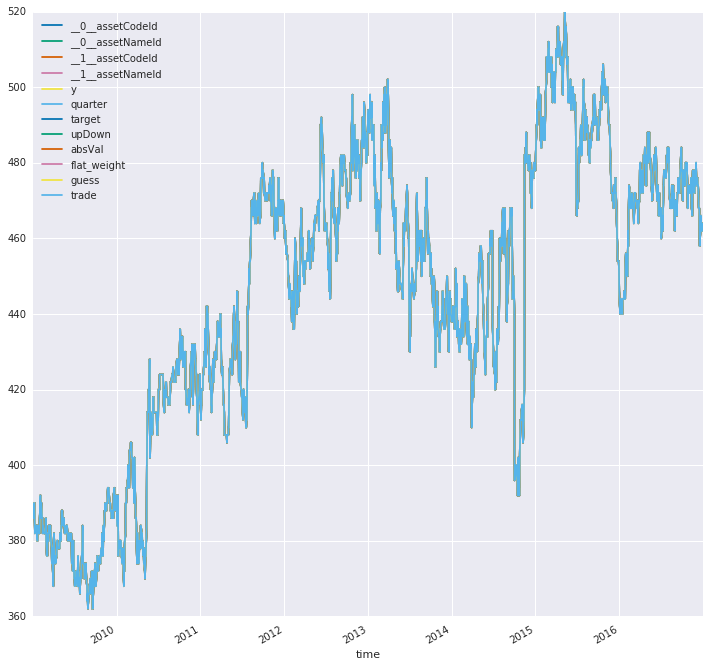

In [86]:
PQ.groupby('time').count().plot();

In [89]:
if TEST:
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)

In [90]:
TRAIN = False

### define the model aggregating function

In [91]:
@inside(themodel)
def guess(*, F, P, W, D):
    weight_map_multiplier = {'vp1_weight':F.vp1/1e9,'vp10_weight':F.vp10/1e9,'flat_weight':1,}
    
    def _pair_func(model, *, F, P):
        FG, PQ = make_pair_features(model,F=F,P=P,W=W,D=D)
        guess = model.bst.predict(FG) * 2 - 1
        del FG; gc.collect()
        return resolve_pair_guess(model, guess, P=P,PQ=PQ)
    
    def tanh_trans(x, P=None):
        center = x.mean()
        return np.tanh((x-center)*7)+center
    
    if P.time.nunique()==1:
        the_trans = tanh_trans
    else:
        def the_trans(x, P):
            P['_x'] = x
            ans = P.groupby('time')._x.transform(tanh_trans)
            return ans
    
    pairs = [np.nan_to_num(_pair_func(s,F=F,P=P) * weight_map_multiplier[s.weight]) * c# / s.bst.std
             for s,c in zip(themodel.pair.specs,themodel.pair.coefs) if c!=0]
    
    solos = [np.nan_to_num(the_trans(s.bst.predict(F[s.features])*2-1,P=P)*weight_map_multiplier[s.weight])*c# / s.bst.std
             for s,c in zip(themodel.solo.specs,themodel.solo.coefs) if c!=0]
    
    BUG.pairs, BUG.solos = pairs, solos
    
    return (sum(solos+pairs)/1000000).clip(-1,1)

### last look at the model blending

In [92]:
[print((spec.__name__ if spec is not None else 'None'), end=', ') for spec in themodel.solo.specs];
# themodel.solo.coefs = []
[print((spec.__name__ if spec is not None else 'None'), end=', ') for spec in themodel.pair.specs];
# themodel.pair.coefs = []

s21, TryIt, IKGCoverThreeMoreShort, pIKGCoverHomo, 

### Look at the holdout results

0.6006967658849921


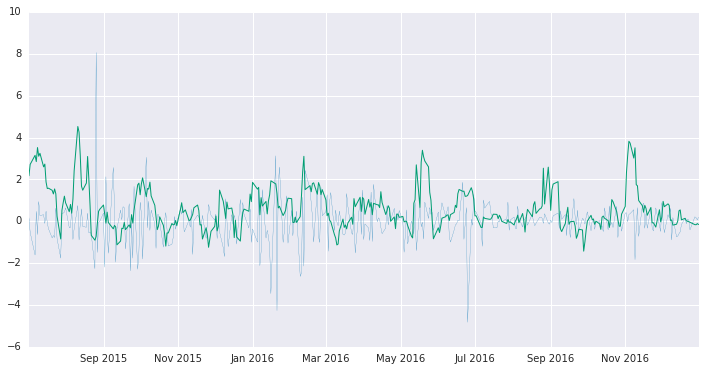

In [93]:
if True:
    try:
        F, P, W, D
    except NameError:
        (F,P,W,D) = pd.read_pickle(FILE_WORK); W, D = O(**W), O(**D)

    ho = P.quarter >= 2015.5
        
    F, P = F[ho], P[ho]; gc.collect()
    P['guess'] = themodel.guess(F=F,P=P,W=W,D=D)
    P.guess = P.guess*(np.abs(P.guess)>=0.0)

    P['trade'] = P.guess*P.upDown*P.absVal

    daily = P[ho].groupby('time').trade.sum()
    print(daily.mean()/(lambda x: x if x!=0 else 1.)(daily.std(ddof=0)))
    plt.hist(daily, bins=80);
    
    time = P[ho].groupby('time').time.first()
    market = F[ho].groupby(P.time).aoo.sum()
    trade = P[ho].groupby('time').trade.sum()
    
    %matplotlib inline
    canvas(12,6)
    plt.plot(time, market/market.std(ddof=0), linewidth=.2);
    plt.plot(time, trade/trade.std(ddof=0), linewidth=1);
    
    del F, P, D, W; gc.collect()

#view_results(ho, F=F,P=P,W=W,D=D)

## +-+-+-+-+-+-+-+-+-+-+-+-+-+-+- Prediction and submission +-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

#### the rest of the administrative pipeline

In [122]:
# __env__ = _make_env() #NOPE remove this cell
# M = pd.read_pickle('../data/given/M.pkl')
# set_basic_features(M=M)
# _M_ = M

In [123]:
try:
    del F, P, W;
except NameError:
    pass
gc.collect()

787

In [124]:
Mstart = pd.read_pickle(FILE_MSTART)

In [125]:
# defines U_ ahead of time for initial start of the feature processing loop in submission stage

set_basic_features(M=Mstart)
U_ = make_U(M=Mstart)
del Mstart; gc.collect()
u_, V_, v_ = OX(), OX(), OX()
add_shortterm_price_features(U=U_,u=u_)
add_longterm_price_features(U=U_,u=u_)
add_global_price_features(U=U_,u=u_,V=V_,v=v_)
del u_, v_; gc.collect()

0

In [126]:
%%time
def do_submission_loop():
    global TIME
    feat_iter = iter_features_templates(__env__.get_prediction_days(), U_=(U_,longterm), V_=(V_,longterm))
    for i, (f, p) in enumerate(feat_iter): #TODO roll M here for pair generation
        print_progress(i)
        # p has assetCode already a column, not the index
        p_ = p.copy()
        p_['time'] = TIME
        setup_P(F=f,P=p_,target=False) # this puts assetCodeId in P
        W = O(aoo=U_._aoo, aooTEN=U_._aooTEN, aooTTY=U_._aooTTY)
        p.confidenceValue = ans = themodel.guess(F=f,P=p_,W=W,D=D)
        if np.isnan(ans).any() or (ans<-1).any() or (ans>1).any():
            BUG.i, BUG.f, BUG.p, BUG.ans = i, f, p, ans
            assert False
        __env__.predict(p)
        gc.collect()
do_submission_loop()

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630........CPU times: user 33min 13s, sys: 1min 12s, total: 34min 25s
Wall time: 20min 36s


In [127]:
__env__.write_submission_file()

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.


# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ LOCAL TESTING ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 